# LSST Simulated False Detections

This notebook contains a False Detection generator for the LSST opsim based Sythetic Solar System Object Observation Catalog. The notebook is based on Jones et al. (2018) and Veres & Chesley (2017).

In [7]:
import numpy as np
import pandas as pd
import sqlite3 as sql

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

import joblib
from joblib.externals.loky import set_loky_pickler
from joblib import parallel_backend
from joblib import wrap_non_picklable_objects
from joblib import Parallel, delayed

In [8]:
# from lsst.sims.utils import ObservationMetaData
# from lsst.sims.coordUtils import lsst_camera
# from lsst.sims.coordUtils import chipNameFromRaDecLSST
# from lsst.afw.cameraGeom import DetectorType
from extern.PPFootprintFilter import *

In [40]:
# update to random number generation
rng = np.random.default_rng( seed=6271998 )

In [35]:
def sampleFOV(npoints, center, rFOV=0.01, ndim=3, rng=np.random.default_rng() ):
    """Sample n points randomly (uniform distribution) on a region on the unit (hyper-)sphere.
    
    Parameters:
    -----------
    npoints ... number of sampled points
    center  ... center of hpyer-sphere
    rFOV    ... radius on unit sphere [radians]
    ndim    ... dimension of hyper-sphere
    seed    ... random seed
    
    Returns:
    --------
    vec ... numpy array of npoints x ndim vectors 
    """
    
    # np.random.seed(seed)
    # randn = np.random.randn
    norm = np.linalg.norm
    select = np.random.choice
    where = np.where
    
    # create a hypercube with int(4pi/3)+2 * npoints points
    # cube = rng.standard_normal(ndim, 6*npoints).T
    cube = rng.standard_normal( (6*npoints, ndim) )
    cube_norm = norm(cube, axis=1)
    
    # select npoints points within a unit sphere and scale to rFOV
    mini_sphere = cube[select(where(cube_norm <= 1.)[0],npoints,replace=False)]*rFOV
    
    # change sphere center to center point on the celestial sphere
    mini_sphere+=center

    # project mini_sphere onto celestial sphere
    [x,y,z] = [mini_sphere[:,0],mini_sphere[:,1],mini_sphere[:,2]]/norm(mini_sphere, axis=1)
    vec=np.array([x,y,z])
    return vec.T

In [11]:
def diaFalseDetectionVmag(nNoise, Vlim, eta0=5):
    """Noise V magnitude of Difference Imaging Artefacts following Veres & Chesley (2017).
    
    Parameters:
    -----------
    nNoise ... number of artifacts
    Vlim   ... m5 liming magntide at eta0=5
    eta0   ... Signal To Noise ratio limit for detection 
    
    Returns:
    --------
    V ... array containing nNoise Vmag values
    """
    
    p=np.random.random_sample(nNoise)
    eta = eta0*(1./(1.-p)**2)**(1./3.)
    V = Vlim - 2.5*np.log(eta/eta0)
    
    return V

In [12]:
def radec2icrfu(ra, dec, deg=True):
    """Convert Right Ascension and Declination to ICRF xyz unit vector.
    Geometric states on unit sphere, no light travel time/aberration correction.
    Parameters:
    -----------
    ra ... Right Ascension [deg]
    dec ... Declination [deg]
    deg ... True: angles in degrees, False: angles in radians
    
    Returns:
    --------
    x,y,z ... 3D vector of unit length (ICRF)
    """
    
    deg2rad=np.deg2rad
    array=np.array
    cos=np.cos
    sin=np.sin
    
    if(deg):
        a = deg2rad(ra)
        d = deg2rad(dec)
    else:
        a = array(ra)
        d = array(dec)
       
    cosd = cos(d)
    x = cosd*cos(a)
    y = cosd*sin(a)
    z = sin(d)

    return array([x, y, z])
   

In [13]:
def icrf2radec(x, y, z, deg=True):
    """Convert ICRF xyz to Right Ascension and Declination.
    Geometric states on unit sphere, no light travel time/aberration correction.
    
    Parameters:
    -----------
    x,y,z ... 3D vector of unit length (ICRF)
    deg ... True: angles in degrees, False: angles in radians
    
    Returns:
    --------
    ra ... Right Ascension [deg]
    dec ... Declination [deg]
    """
    
    norm=np.linalg.norm
    array=np.array
    arctan2=np.arctan2
    arcsin=np.arcsin
    rad2deg=np.rad2deg
    modulo=np.mod
    pix2=2.*np.pi
    
    pos=array([x,y,z])
    if(pos.ndim>1):
        r=norm(pos,axis=0)
    else:
        r=norm(pos)
    
    xu=x/r
    yu=y/r
    zu=z/r
    
    phi=arctan2(yu,xu)
    delta=arcsin(zu)
    
    if(deg):
        ra = modulo(rad2deg(phi)+360,360)
        dec = rad2deg(delta)
    else:
        ra = modulo(phi+pix2,pix2)
        dec = delta
        
    return ra, dec

In [14]:
# def cameraFootprintFilter(ephems,obsdf,raname='fieldRA',decname='fieldDec',obsIdname='observationId', 
#                    obsepochname='observationStartMJD',rotskyname='rotSkyPos',
#                          raNameEph='AstRA(deg)',decNameEph='AstDec(deg)',
#                          obsIdNameEph='observationId'):
    
#     """LSST Cam footprint filter. Filter RADEC observation 
#     data bases for observations that do not fall on science chips on the camera.
    
#     Parameters:
#     ----------- 
#     ephems ... observations containing RA and Dec data
#     obsdf  ... opsim database (pandas dataFrame)

#     Returns:
#     ephemsOut ... filtered observations
#     """
    

#     camera = lsst_camera()
#     ccd_type_dict = {DetectorType.SCIENCE: 'science', DetectorType.WAVEFRONT: 'wavefront',
#                  DetectorType.GUIDER: 'guider', DetectorType.FOCUS: 'focus'}
    
#     ephemsFiltered=[]
#     i=0
#     for index, row in obsdf.iterrows(): 

#         obs_metadata = ObservationMetaData(pointingRA=row[raname],
#                                            pointingDec=row[decname],
#                                            rotSkyPos=row[rotskyname],
#                                            mjd=row[obsepochname])

#         ephems_sel=ephems[ephems[obsIdNameEph] == row[obsIdname]].reset_index(drop=True)

        
#         chipName = chipNameFromRaDecLSST(ra=ephems_sel[raNameEph].values.astype(float),
#                                          dec=ephems_sel[decNameEph].values.astype(float),
#                                             epoch=2000.0, obs_metadata=obs_metadata)


#         idx=np.where(chipName != None)[0]
#         idxObs=[i for i in idx if (ccd_type_dict[camera[chipName[i]].getType()] == 'science')]
#         ephemsFiltered.append(ephems_sel[ephems_sel.index.isin(idxObs)])
    
#     ephemsOut=pd.concat(ephemsFiltered).reset_index(drop=True)
#     return ephemsOut

In [49]:
def getSqlData(database,rows_start,nrows, columns=None):
    """Import dataset from local SQL database
    
    Parameters:
    -----------
    database   ... path to database
    rows_start ... number of row to start
    rows_max   ... number of rows to select
    
    Returns:
    --------
    observations ... pandas dataframe containing observations from JPL database
    """
    if columns is None:
        query_string = """SELECT * FROM observations LIMIT """+str(rows_start)+','+str(nrows)
    else:
        columns_string = ', '.join( columns )
        query_string = 'SELECT ' + columns_string + " FROM observations LIMIT "+str(rows_start)+','+str(nrows)

    con = sql.connect(database)
    observations = pd.read_sql(query_string, con)
    return observations

In [16]:
def makeFalseDetectionsFiles(rowStart,nRows, db_path, rng=np.random.default_rng() ):
    """Generate False Detections due to Difference Image Artifacts 
    for a given opsim survey simulation and save them as csv files.
    
    Parameters:
    -----------
    rowStart    ... start row of opsim SQL data base
    nRows       ... how many rows should be processed
    db_path     ... path to opsim SQL data base
    seed        ... random seed
    """
    LSSTdf=getSqlData(db_path,rowStart,nRows)
    FDdf, nFDlist=createDiaFalseDetections(LSSTdf,minFD=350,maxFD=440, rng=rng)

    FDFiltered=cameraFootprintFilter(FDdf,LSSTdf,raname='fieldRA',decname='fieldDec',obsIdname='observationId', 
                   obsepochname='observationStartMJD',rotskyname='rotSkyPos')
    
    outfile='./data/false_detections_fbs-v1_5-2snaps_'+str(rowStart).zfill(7)+'.csv'
    FDFiltered.to_csv(outfile,index=False)
    return 'Ok'

In [17]:
def makeRandomNoiseFiles(rowStart,nRows,db_path, rng=np.random.default_rng() ):
    """Generate False Detections from random noise for a given opsim survey 
    simulation and save them as csv files.
    
    Parameters:
    -----------
    rowStart    ... start row of opsim SQL data base
    nRows       ... how many rows should be processed
    db_path     ... path to opsim SQL data base
    seed        ... random seed
    """
    LSSTdf=getSqlData(db_path,rowStart,nRows)
    NSdf, nNSlist=createRandomNoise(LSSTdf,nLim=1000,rng=rng)
    NSFiltered=cameraFootprintFilter(NSdf,LSSTdf,raname='fieldRA',decname='fieldDec',obsIdname='observationId', 
                   obsepochname='observationStartMJD',rotskyname='rotSkyPos')
    outfile='./data/random_noise_fbs-v1_5-2snaps_'+str(rowStart).zfill(7)+'.csv'
    NSFiltered.to_csv(outfile,index=False)
    return 'Ok'

In [18]:
def flux2mag(f,  f0=3631):
    """AB ugriz system (f0 = 3631 Jy) to magnitude conversion

       Parameters:
       -----------
       f  ... flux [Jy]
       f0 ... zero point flux
   
       Returns:
       --------
       mag ... pogson magnitude
    """
    mag=-2.5*np.log10(f/f0)
    
    return mag

In [19]:
def calcAstrometricError(mag, m5, nvisit=1, FWHMeff=700.0, error_sys = 10.0, astErrCoeff=0.60, output_units='mas'):
    """Calculate the astrometric error, for object catalog purposes.
    The effective FWHMeff MUST BE given in miliarcsec (NOT arcsec!).
    Systematic error, error_sys, must be given in miliarcsec.
    
    Parameters:
    -----------
        mag            ...    magnitude of the observation
        m5             ...    5 sigma limiting magnitude
        nvisit         ...    number of visits to consider
        FWHMeff        ...    effective Full Width at Half Maximum of Point Spread Function [mas]
        error_sys      ...    sytstematic error [mas]
        output_units   ...    'mas' (default): milliarcseconds, 'arcsec': arcseconds
    
    Returns:
    ---------
        astrom_error   ...    astrometric error 
        SNR            ...    signal to noise ratio
        error_rand     ...    random error
        
    *** This error corresponds to a single-coordinate error ***
    the total astrometric error (e.g. relevant when
    matching two catalogs) will be sqrt(2) times larger!
    """
    # The astrometric error can be applied to parallax or proper motion (for nvisit>1).
    # If applying to proper motion, should also divide by the # of years of the survey.
    # This is also referenced in the LSST overview paper (arXiv:0805.2366, ls.st/lop)
    #
    # Notes:
    # - assumes sqrt(Nvisit) scaling, which is the best-case scenario
    # - calcRandomAstrometricError assumes maxiumm likelihood solution,
    # which is also the best-case scenario
    # - the systematic error, error_sys = 10 mas, corresponds to the
    # design spec from the LSST Science Requirements Document (ls.st/srd)
    #
    # first compute SNR
    
    power=np.power
    sqrt=np.sqrt
    
    
    rgamma = 0.039
    xval = power(10, 0.4*(mag-m5))
    SNR = 1./sqrt((0.04-rgamma)*xval + rgamma*xval*xval)
    # random astrometric error for a single visit
    error_rand = calcRandomAstrometricErrorPerCoord(FWHMeff, SNR, astErrCoeff)
    # random astrometric error for nvisit observations
    if (nvisit > 1):
        error_rand = error_rand / sqrt(nvisit)
    # add systematic error floor:
    astrom_error = sqrt(error_sys * error_sys + error_rand*error_rand)
    
    if (output_units=='arcsec'):
        astrom_error=astrom_error/1000
        error_rand=error_rand/1000
    
    return astrom_error, SNR, error_rand

def calcRandomAstrometricErrorPerCoord(FWHMeff, SNR, AstromErrCoeff = 0.60):
    """Calculate the random astrometric error, as a function of
    effective FWHMeff and signal-to-noise ratio SNR
    Returns astrometric error in the same units as FWHM.
    ** This error corresponds to a single-coordinate error **
    the total astrometric error (e.g. relevant when matching
    two catalogs) will be sqrt(2) times larger.

    The coefficient AstromErrCoeff for Maximum Likelihood
    solution is given by 
       AstromErrCoeff = <P^2> / <|dP/dx|^2> * 1/FWHMeff
    where P is the point spread function, P(x,y). 

    For a single-Gaussian PSF, AstromErrCoeff = 0.60
    For a double-Gaussian approximation to Kolmogorov 
    seeing, AstromErrCoeff = 0.55; however, given the 
    same core seeing (FWHMgeom) as for a single-Gaussian
    PSF, the resulting error will be 36% larger because
    FWHMeff is 1.22 times larger and SNR is 1.22 times
    smaller, compared to error for single-Gaussian PSF.
    Although Kolmogorov seeing is a much better approximation
    of the free atmospheric seeing than single Gaussian seeing, 
    the default value of AstromErrCoeff is set to the
    more conservative value.
    Note also that AstromErrCoeff = 1.0 is often used in
    practice to empirically account for other error sources.

    The <June2020 version of this code used AstromErrCoeff=1.0
    and FWHMgeom instead of FWHMeff. Given that 
    FWHMeff/FWHMgeom=1.22 for Kolmogorov seeing, the old 
    version was within 3% from the total astrometric error 
    (that is, not error per coordinate, but sqrt(2) larger)
    produced with this updated version.
    """
    return AstromErrCoeff * FWHMeff / SNR 

def magErrorFromSNR(snr):
    """
    convert flux signal to noise ratio to an error in magnitude
    @param [in] snr is the signal to noise ratio in flux
    @param [out] the resulting error in magnitude
    """

    log10=np.log10
    
    #see www.ucolick.org/~bolte/AY257/s_n.pdf section 3.1
    return 2.5*log10(1.0+1.0/snr)

In [20]:
def NrandomNoise(seeingFWHM=1, S=4000*4000, SNR=5,  arcsec_per_pixel=0.2):
    """ LSST detector random noise model (Kaiser, 2004). Gives the number 
    of false detections due to Gaussian random fluctuations in the sky background 
    and detector noise for a given SNR.
    
    Parameters:
    -----------
    seeingFWHM      ... seeing Full Width Half Maximum in arcsec
    S               ... total number of pixels on sensor (ncols*nrows)
    SNR             ... signal-to-noise threshold for detection (e.g. 5)
    arcsec_per_pixel... number of arcseconds per pixel
    
    Returns:
    Nfd             ... number of false detections on sensor
    """

    # sigma_g is the FWHM seeing measured in pixels 
    sigma_g = seeingFWHM/arcsec_per_pixel/2.35
    
    # Gaussian background noise,convolved with a Gaussian point spread function (PSF) 
    # with width sigma_g
    # Number of noise detections for SNRs > SNR
    Nfd = S*SNR*np.exp(-(SNR**2)/2.)/(2.**2.5*np.pi**1.5*sigma_g**2)
    return Nfd

In [21]:
def createDiaFalseDetections(obsdf, minFD=100,maxFD=800, rOnSky=2.3,
                             nFDlim=3500, rng=np.random.default_rng(),
                             raName='fieldRA',decName='fieldDec',obsIdName='observationId', 
                             obsEpochName='observationStartMJD',limMagName='fiveSigmaDepth',
                             seeingName='seeingFwhmEff',filterName='filter',fieldIdName='fieldId',
                             outCols=['ObjID','observationId', 'FieldMJD', 'AstRange(km)', 
                            'AstRangeRate(km/s)', 'AstRA(deg)','AstRARate(deg/day)',
                            'AstDec(deg)', 'AstDecRate(deg/day)', 'Ast-Sun(J2000x)(km)',
                            'Ast-Sun(J2000y)(km)', 'Ast-Sun(J2000z)(km)', 
                            'Sun-Ast-Obs(deg)', 'V','Filtermag','V(H=0)', 'Filter',           
                            'AstRASigma(mas)', 'AstDecSigma(mas)','PhotometricSigma(mag)']):

    """Create simulated Difference Image Artifact False Detections 
    assuming a Gaussian distribution between n = minFD(-3sigma)
    and maxFD (+3 sigma) where n is the number of diaSources per 
    square degree on the sky. 
    Random RADEC positions are generated on uniformly the unit sphere. For every visit field of view 
    points within rOnSky are selected through a KDTree query. This avoids issues at celestial poles. 
    Magnitudes are drawn according to Veres & Chesley (2017). 
    The function returns circles in RA and DEC of radius rOnSky.
    
    Parameters:
    -----------
    obsdf             ... pandas DataFrame containing LSST observations (from opsim)
    minFD             ... minimum number of DiaSources/deg^2
    maxFD             ... maximum number of DiaSources/deg^2
    rOnSky            ... radius of sky area around LSST pointing (pi*rsky^2) [deg] 
    nFDlim            ... limit number of False Detections per square degree
    seed              ... seed for pseudo random number generator
    raName            ... field name for Right Ascension 
    decName           ... field name for Declination
    obsIdName         ... field name for observation ID
    obsEpochName      ... field name for observation epoch
    limMagName        ... field name for limiting magnitude
    outCols           ... ouput column names
    
    Returns:
    --------
    FDdf             ... pandas DataFrame with noise positions in RADEC
    nFDlist          ... list of number of false detections per square degree for every LSST visit/exposure
    """
    
    # external:
    # NUMPY
    pi = np.pi
    normal = rng.normal
    uniform = rng.uniform
    rint = np.rint
    sin = np.sin
    cos = np.cos
    sqrt = np.sqrt
    choose = rng.choice
    deg2rad = np.deg2rad
    array = np.array
    mean = np.mean
    std = np.std
    
    # np.random.seed(seed)
 
    # PANDAS
    DataFrame = pd.DataFrame
    concat = pd.concat
    
    # initialize lists
    listdf = []
    nFDlist = []
    
    # False Detection/deg^2 statistics
    meanFD=0.5*(maxFD+minFD)
    sigmaFD=(maxFD-meanFD)/3.
    
    # Create FDs on Sky (unit sphere)
    nFDperSqDeg=3*maxFD
    sqDegInSphere=rint(360**2/pi).astype(int)

    skyArea=rint(rOnSky**2*pi).astype(int)
    r=deg2rad(rOnSky)
    
    for index, row in obsdf.iterrows():
        
        # convert radec to ICRF unit vector
        x = radec2icrfu(row[raName],row[decName])

        # How many FDs do we expect in the current sky area?
        nFD = skyArea*rint(normal(loc=meanFD,scale=sigmaFD)).astype(int)
    
        # Create random sample of points in FOV 
        sample = sampleFOV(nFD,x,deg2rad(rOnSky))
        
        # convert them to RADEC
        [ra, dec] = icrf2radec(sample[:,0],sample[:,1],sample[:,2])
        radec = array([ra,dec]).T

        # Determine Vmag of the noise following Veres & Chesley 2017. 
        filterMag=diaFalseDetectionVmag(nFD, row[limMagName], eta0=5)
        
        # Astrometric and photometric 1 sigma uncertainties
        astrSig,SNR,rndError = calcAstrometricError(filterMag, row[limMagName], 
                                                    FWHMeff=row[seeingName]*1000, output_units='mas')
        photSig = magErrorFromSNR(SNR)
        
        # Create pandas dataFrame
        df=DataFrame(index=range(nFD),columns=outCols)
        df[['AstRA(deg)','AstDec(deg)']]=radec
        df['FieldMJD'] = row[obsEpochName]
        df['ObjID']='FD'
        df['Filtermag'] = filterMag[0:nFD]
        df['Filter']=row[filterName]
        df['observationId'] = row[obsIdName]
        df['AstRASigma(mas)'] = astrSig
        df['AstDecSigma(mas)'] = astrSig
        df['PhotometricSigma(mag)'] = photSig
        
        listdf.append(df)
        nFDlist.append(nFD/skyArea)

    # concatenate results dataFrame    
    FDdf=concat(listdf).reset_index(drop=True)
    
    
    print('mean, sigma of number of False Detections per square degree', 
          int(mean(array(nFDlist))),',',int(std(array(nFDlist))))

    return FDdf, nFDlist

In [22]:
def randomNoiseVmag(nNS, m5, eta0=5, rng=np.random.default_rng() ):
    """Determine mangitude of random noise artifacts in LSST images.
    
    Parameters:
    -----------
    nNS  ... number of noise sources
    eta0 ... SNR threshold
    m5   ... limiting magnitude (5 sigma)
    
    Returns:
    --------
    Vmag ... array of V magnitudes
    """
    # external:
    # NUMPY
    # np.random.seed(seed)
    uniform=rng.uniform
    sqrt=np.sqrt
    log10=np.log10
    
    p=uniform(0,1,nNS)
    eta=sqrt(eta0**2-2.*log10(1.-p))
    Vmag=m5-2.5*log10(eta/eta0)
    return Vmag

In [25]:
def createRandomNoise(obsdf, rOnSky=2.3, nLim=1000, SNRlim=5, 
                      nPixel=4000*4000*189, arcsec_per_pixel=0.2, rng=np.random.default_rng(),
                      raName='fieldRA',decName='fieldDec',obsIdName='observationId', 
                      obsEpochName='observationStartMJD',limMagName='fiveSigmaDepth',
                      seeingName='seeingFwhmEff',filterName='filter',fieldIdName='fieldId',
                      outCols=['ObjID','observationId', 'FieldMJD', 'AstRange(km)', 
                     'AstRangeRate(km/s)', 'AstRA(deg)','AstRARate(deg/day)',
                     'AstDec(deg)', 'AstDecRate(deg/day)', 'Ast-Sun(J2000x)(km)',
                     'Ast-Sun(J2000y)(km)', 'Ast-Sun(J2000z)(km)', 
                     'Sun-Ast-Obs(deg)', 'V','Filtermag','V(H=0)', 'Filter',           
                     'AstRASigma(mas)', 'AstDecSigma(mas)','PhotometricSigma(mag)']):

    """Create simulated random noise following Jones et al. (2018) and Veres & Chesley (2017). 
    Random RADEC positions are generated on uniformly the unit sphere. For every visit field of view 
    points within rOnSky are selected through a KDTree query. This avoids issues at celestial poles. 
    Magnitudes are drawn according to Veres & Chesley (2017).
    
    
    Parameters:
    -----------
    obsdf             ... pandas DataFrame containing LSST observations (from opsim)
    rOnSky            ... radius of sky area around LSST pointing (pi*rsky^2) [deg]
    nLim              ... limit number of noise sources per square degree
    nPixel            ... number of pixels in camera
    seed              ... seed for pseudo random number generator
    arcsec_per_pixel  ... arcseconds per pixel
    raName            ... field name for Right Ascension 
    decName           ... field name for Declination
    obsIdName         ... field name for observation ID
    obsEpochName      ... field name for observation epoch
    limMagName        ... field name for limiting magnitude
    outCols           ... output column names
    
    Returns:
    --------
    NSdf             ... pandas DataFrame with noise positions in RADEC
    nNSlist          ... list of number of noise detections per square degree for every LSST visit/exposure
    
    """
    
    # external:
    # NUMPY
    pi=np.pi
    normal=rng.normal
    uniform=rng.uniform
    rint=np.rint
    sin=np.sin
    cos=np.cos
    sqrt=np.sqrt
    choose=rng.choice
    deg2rad=np.deg2rad
    array=np.array
    mean=np.mean
    std=np.std
    
    # rng.seed(seed)
    
    # PANDAS
    DataFrame = pd.DataFrame
    concat = pd.concat
 
    listdf = []
    nNSlist = []
    
    # Create FDs on Sky (unit sphere)
    sqDegInSphere=rint(360**2/pi).astype(int)
    skyArea=rint(rOnSky**2*pi).astype(int)
    r=deg2rad(rOnSky)
  
    nLimFOV=rint(skyArea*nLim).astype(int)

    for index, row in obsdf.iterrows():
        
        # convert radec to ICRF unit vector
        x=radec2icrfu(row[raName],row[decName])
        
        # How many NS sources do we expect in the current sky area?
        nNS=rint(NrandomNoise(seeingFWHM=row[seeingName], S=nPixel, SNR=5, 
                        arcsec_per_pixel=0.2)).astype(int)
        if(nNS>nLimFOV):
            print('nNS/deg^2>nLim:',nNS/skyArea,nLim)
            print('seeing:',row[seeingName])
            nNS=nLimFOV

        sample=sampleFOV(nNS,x,deg2rad(rOnSky), rng=rng)
        
        [ra, dec]=icrf2radec(sample[:,0],sample[:,1],sample[:,2])
    
        radec=array([ra,dec]).T

        # Determine Vmag of the noise following Veres & Chesley 2017. 
        filterMag=randomNoiseVmag(nNS, row[limMagName], eta0=5, rng=rng)
        
        # Astrometric and photometric 1 sigma uncertainties
        astrSig,SNR,rndError = calcAstrometricError(filterMag, row[limMagName], 
                                                    FWHMeff=row[seeingName]*1000, output_units='mas')
        photSig = magErrorFromSNR(SNR)
        
        df=DataFrame(index=range(nNS),columns=outCols)
        df[['AstRA(deg)','AstDec(deg)']]=radec
        df['FieldMJD'] = row[obsEpochName]
        df['ObjID']='FD'
        df['Filtermag'] = filterMag[0:nNS]
        df['Filter']=row[filterName]
        df['observationId'] = row[obsIdName]
        df['AstRASigma(mas)'] = astrSig
        df['AstDecSigma(mas)'] = astrSig
        df['PhotometricSigma(mag)'] = photSig
        
        listdf.append(df)
        nNSlist.append(nNS/skyArea)

    NSdf=concat(listdf).reset_index(drop=True)
    
    
    # print('mean, sigma of number of random noise per square degree', # ?
    #       int(mean(array(nFDlist))/skyArea),',',int(std(array(nFDlist))/skyArea))

    return NSdf, nNSlist

In [26]:
def plotFilteredFootprint(df, dfFiltered, raName='AstRA(deg)', decName='AstDec(deg)', title='LSST CAM Field',
                         label1='FD sample',label2='FDs footprint filtered'):
    """Compare filtered camera footprint with circular stamp."""
    plt.figure(dpi=300, figsize=(6,6))
    plt.scatter(df[raName],df[decName],s=0.04,label=label1)
    plt.scatter(dfFiltered[raName],dfFiltered[decName],s=0.02,label=label2)
    plt.xlabel('RA [deg]')
    plt.ylabel('DEC [deg]')
    plt.title(title)
    plt.legend()
    plt.show()

## Import LSST Opsim database 
This database contains LSST pointings and environmental information such as seeing.


In [27]:
# db_path="../opsim/baseline_2snaps_v1.5_10yrs.db"
db_path='./data/baseline_v3.3_10yrs.db'

Select the first ten exposures of the LSST survey for testing purposes

In [54]:
LSSTdf=getSqlData(db_path,0,10, columns=[
    'observationStartMJD',
    'observationId',
    'fieldRA',
    'fieldDec',
    'rotSkyPos',
    'filter',
    'seeingFwhmEff',
    'fiveSigmaDepth'
])

In [55]:
LSSTdf

observationStartMJD  observationId     fieldRA   fieldDec   rotSkyPos  \
0         60796.001439              0  200.782211 -50.116498  127.004974   
1         60796.001888              1  205.280457 -48.985871  131.267782   
2         60796.002335              2  208.768832 -50.721324  132.267923   
3         60796.002782              3  212.491654 -52.367602  133.668624   
4         60796.003233              4  209.531249 -47.656241  135.334500   
5         60796.003679              5  213.034725 -49.263381  136.397213   
6         60796.004128              6  217.046105 -47.648534  140.381643   
7         60796.004574              7  216.747682 -50.772963  137.704962   
8         60796.005021              8  220.676572 -52.170370  139.490983   
9         60796.005469              9  216.464853 -53.909493  134.825598   

  filter  seeingFwhmEff  fiveSigmaDepth  
0      r       1.193026       23.960375  
1      r       1.222970       23.914426  
2      r       1.253691       23.864850  
3      r       1.288305       23.812580  
4      r       1.257907       23.854248  
5      r       1.291638       23.801367  
6      r       1.338646       23.736268  
7      r       1.327847       23.757836  
8      r       1.213908       23.825612  
9      r       1.167897       23.909109

Create False Detections according to Veres & Chesley (2017). 

In [56]:
FDdf, nFDlist=createDiaFalseDetections(LSSTdf,minFD=350,maxFD=440)

mean, sigma of number of False Detections per square degree 393 , 12


In [57]:
FDdf

ObjID  observationId      FieldMJD AstRange(km) AstRangeRate(km/s)  \
0        FD              0  60796.001439          NaN                NaN   
1        FD              0  60796.001439          NaN                NaN   
2        FD              0  60796.001439          NaN                NaN   
3        FD              0  60796.001439          NaN                NaN   
4        FD              0  60796.001439          NaN                NaN   
...     ...            ...           ...          ...                ...   
66890    FD              9  60796.005469          NaN                NaN   
66891    FD              9  60796.005469          NaN                NaN   
66892    FD              9  60796.005469          NaN                NaN   
66893    FD              9  60796.005469          NaN                NaN   
66894    FD              9  60796.005469          NaN                NaN   

       AstRA(deg) AstRARate(deg/day)  AstDec(deg) AstDecRate(deg/day)  \
0      201.692448                NaN   -49.275553                 NaN   
1      198.250116                NaN   -49.196137                 NaN   
2      200.116637                NaN   -49.114170                 NaN   
3      201.898344                NaN   -48.405950                 NaN   
4      202.889242                NaN   -49.744663                 NaN   
...           ...                ...          ...                 ...   
66890  214.038876                NaN   -52.685823                 NaN   
66891  214.619082                NaN   -55.370282                 NaN   
66892  219.563695                NaN   -53.682448                 NaN   
66893  213.706049                NaN   -53.473446                 NaN   
66894  214.894088                NaN   -54.371026                 NaN   

      Ast-Sun(J2000x)(km) Ast-Sun(J2000y)(km) Ast-Sun(J2000z)(km)  \
0                     NaN                 NaN                 NaN   
1                     NaN                 NaN                 NaN   
2                     NaN                 NaN                 NaN   
3                     NaN                 NaN                 NaN   
4                     NaN                 NaN                 NaN   
...                   ...                 ...                 ...   
66890                 NaN                 NaN                 NaN   
66891                 NaN                 NaN                 NaN   
66892                 NaN                 NaN                 NaN   
66893                 NaN                 NaN                 NaN   
66894                 NaN                 NaN                 NaN   

      Sun-Ast-Obs(deg)    V  Filtermag V(H=0) Filter  AstRASigma(mas)  \
0                  NaN  NaN  23.245507    NaN      r        75.633388   
1                  NaN  NaN  23.807116    NaN      r       124.952305   
2                  NaN  NaN  22.180030    NaN      r        30.849907   
3                  NaN  NaN  23.957684    NaN      r       143.162841   
4                  NaN  NaN  23.362296    NaN      r        83.880380   
...                ...  ...        ...    ...    ...              ...   
66890              NaN  NaN  23.279208    NaN      r        79.851855   
66891              NaN  NaN  23.169845    NaN      r        72.491144   
66892              NaN  NaN  22.886445    NaN      r        56.590305   
66893              NaN  NaN  23.650254    NaN      r       111.240405   
66894              NaN  NaN  23.767586    NaN      r       123.639274   

       AstDecSigma(mas)  PhotometricSigma(mag)  
0             75.633388               0.108143  
1            124.952305               0.174170  
2             30.849907               0.043387  
3            143.162841               0.197511  
4             83.880380               0.119497  
...                 ...                    ...  
66890         79.851855               0.116293  
66891         72.491144               0.105908  
66892         56.590305               0.083044  
66893        111.240

#### Load camera footprint

In [58]:
# FDFiltered=cameraFootprintFilter(FDdf,LSSTdf,raname='fieldRA',decname='fieldDec',obsIdname='observationId', 
#                    obsepochname='observationStartMJD',rotskyname='rotSkyPos')
camera = Footprint( "./extern/ccd_corners.csv" )
# LSSTdf_subset = LSSTdf[ [] ]
fp_det_copy = pd.merge( FDdf, LSSTdf, 
                        how='left', 
                        left_on='observationId',
                        right_on='observationId',
                        )

In [59]:
fp_det_copy

ObjID  observationId      FieldMJD AstRange(km) AstRangeRate(km/s)  \
0        FD              0  60796.001439          NaN                NaN   
1        FD              0  60796.001439          NaN                NaN   
2        FD              0  60796.001439          NaN                NaN   
3        FD              0  60796.001439          NaN                NaN   
4        FD              0  60796.001439          NaN                NaN   
...     ...            ...           ...          ...                ...   
66890    FD              9  60796.005469          NaN                NaN   
66891    FD              9  60796.005469          NaN                NaN   
66892    FD              9  60796.005469          NaN                NaN   
66893    FD              9  60796.005469          NaN                NaN   
66894    FD              9  60796.005469          NaN                NaN   

       AstRA(deg) AstRARate(deg/day)  AstDec(deg) AstDecRate(deg/day)  \
0      201.692448                NaN   -49.275553                 NaN   
1      198.250116                NaN   -49.196137                 NaN   
2      200.116637                NaN   -49.114170                 NaN   
3      201.898344                NaN   -48.405950                 NaN   
4      202.889242                NaN   -49.744663                 NaN   
...           ...                ...          ...                 ...   
66890  214.038876                NaN   -52.685823                 NaN   
66891  214.619082                NaN   -55.370282                 NaN   
66892  219.563695                NaN   -53.682448                 NaN   
66893  213.706049                NaN   -53.473446                 NaN   
66894  214.894088                NaN   -54.371026                 NaN   

      Ast-Sun(J2000x)(km)  ... AstRASigma(mas) AstDecSigma(mas)  \
0                     NaN  ...       75.633388        75.633388   
1                     NaN  ...      124.952305       124.952305   
2                     NaN  ...       30.849907        30.849907   
3                     NaN  ...      143.162841       143.162841   
4                     NaN  ...       83.880380        83.880380   
...                   ...  ...             ...              ...   
66890                 NaN  ...       79.851855        79.851855   
66891                 NaN  ...       72.491144        72.491144   
66892                 NaN  ...       56.590305        56.590305   
66893                 NaN  ...      111.240405       111.240405   
66894                 NaN  ...      123.639274       123.639274   

      PhotometricSigma(mag) observationStartMJD     fieldRA   fieldDec  \
0                  0.108143        60796.001439  200.782211 -50.116498   
1                  0.174170        60796.001439  200.782211 -50.116498   
2                  0.043387        60796.001439  200.782211 -50.116498   
3                  0.197511        60796.001439  200.782211 -50.116498   
4                  0.119497        60796.001439  200.782211 -50.116498   
...                     ...                 ...         ...        ...   
66890              0.116293        60796.005469  216.464853 -53.909493   
66891              0.105908        60796.005469  216.464853 -53.909493   
66892              0.083044        60796.005469  216.464853 -53.909493   
66893              0.159370        60796.005469  216.464853 -53.909493   
66894              0.175892        60796.005469  216.464853 -53.909493   

        rotSkyPos  filter  seeingFwhmEff  fiveSigmaDepth  
0      127.004974       r       1.193026       23.960375  
1      127.004974       r       1.193026       23.960375  
2      127.004974       r       1.193026       23.960375  
3      127.004974       r       1.193026       23.960375  
4      127.004974       r       1.193026       23.960375  
...           ...     ...            ...             ...  
66890  134.825598       r       1.167897       23.909109  
66891  134.825598       r       1.167897       23.

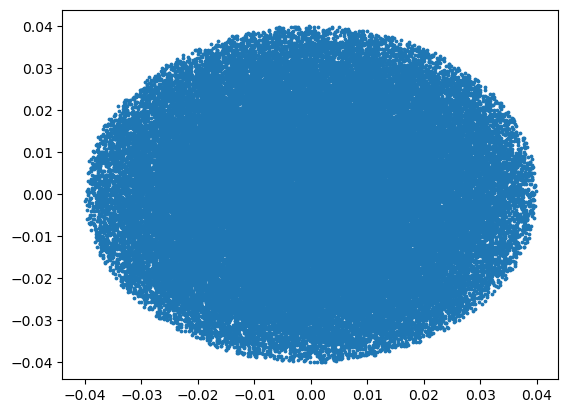

In [63]:
detected_idx, _ = camera.applyFootprint( fp_det_copy );
FDFiltered = FDdf.iloc[ detected_idx ]

In [64]:
FDFiltered

ObjID  observationId      FieldMJD AstRange(km) AstRangeRate(km/s)  \
1286     FD              0  60796.001439          NaN                NaN   
2215     FD              0  60796.001439          NaN                NaN   
2301     FD              0  60796.001439          NaN                NaN   
2318     FD              0  60796.001439          NaN                NaN   
2597     FD              0  60796.001439          NaN                NaN   
...     ...            ...           ...          ...                ...   
65312    FD              9  60796.005469          NaN                NaN   
65489    FD              9  60796.005469          NaN                NaN   
66329    FD              9  60796.005469          NaN                NaN   
66598    FD              9  60796.005469          NaN                NaN   
66605    FD              9  60796.005469          NaN                NaN   

       AstRA(deg) AstRARate(deg/day)  AstDec(deg) AstDecRate(deg/day)  \
1286   203.659493                NaN   -49.989258                 NaN   
2215   203.699949                NaN   -49.913068                 NaN   
2301   203.593787                NaN   -49.828049                 NaN   
2318   203.702097                NaN   -49.970382                 NaN   
2597   203.457308                NaN   -49.824135                 NaN   
...           ...                ...          ...                 ...   
65312  213.227054                NaN   -54.433680                 NaN   
65489  213.230260                NaN   -54.400031                 NaN   
66329  213.137911                NaN   -54.334236                 NaN   
66598  213.152945                NaN   -54.342368                 NaN   
66605  213.149770                NaN   -54.409176                 NaN   

      Ast-Sun(J2000x)(km) Ast-Sun(J2000y)(km) Ast-Sun(J2000z)(km)  \
1286                  NaN                 NaN                 NaN   
2215                  NaN                 NaN                 NaN   
2301                  NaN                 NaN                 NaN   
2318                  NaN                 NaN                 NaN   
2597                  NaN                 NaN                 NaN   
...                   ...                 ...                 ...   
65312                 NaN                 NaN                 NaN   
65489                 NaN                 NaN                 NaN   
66329                 NaN                 NaN                 NaN   
66598                 NaN                 NaN                 NaN   
66605                 NaN                 NaN                 NaN   

      Sun-Ast-Obs(deg)    V  Filtermag V(H=0) Filter  AstRASigma(mas)  \
1286               NaN  NaN  23.096037    NaN      r        66.312922   
2215               NaN  NaN  22.623207    NaN      r        44.174927   
2301               NaN  NaN  22.708878    NaN      r        47.482975   
2318               NaN  NaN  23.430336    NaN      r        89.116237   
2597               NaN  NaN  22.311785    NaN      r        34.222679   
...                ...  ...        ...    ...    ...              ...   
65312              NaN  NaN  23.354533    NaN      r        85.377604   
65489              NaN  NaN  20.287071    NaN      r        11.904238   
66329              NaN  NaN  23.510692    NaN      r        98.147303   
66598              NaN  NaN  23.702142    NaN      r       116.557519   
66605              NaN  NaN  23.067576    NaN      r        66.258311   

       AstDecSigma(mas)  PhotometricSigma(mag)  
1286          66.312922               0.095139  
2215          44.174927               0.063378  
2301          47.482975               0.068217  
2318          89.116237               0.126635  
2597          34.222679               0.048541  
...                 ...                    ...  
65312         85.377604               0.124015  
65489         11.904238               0.009961  
66329         98.147303               0.141628  
66598        116.557

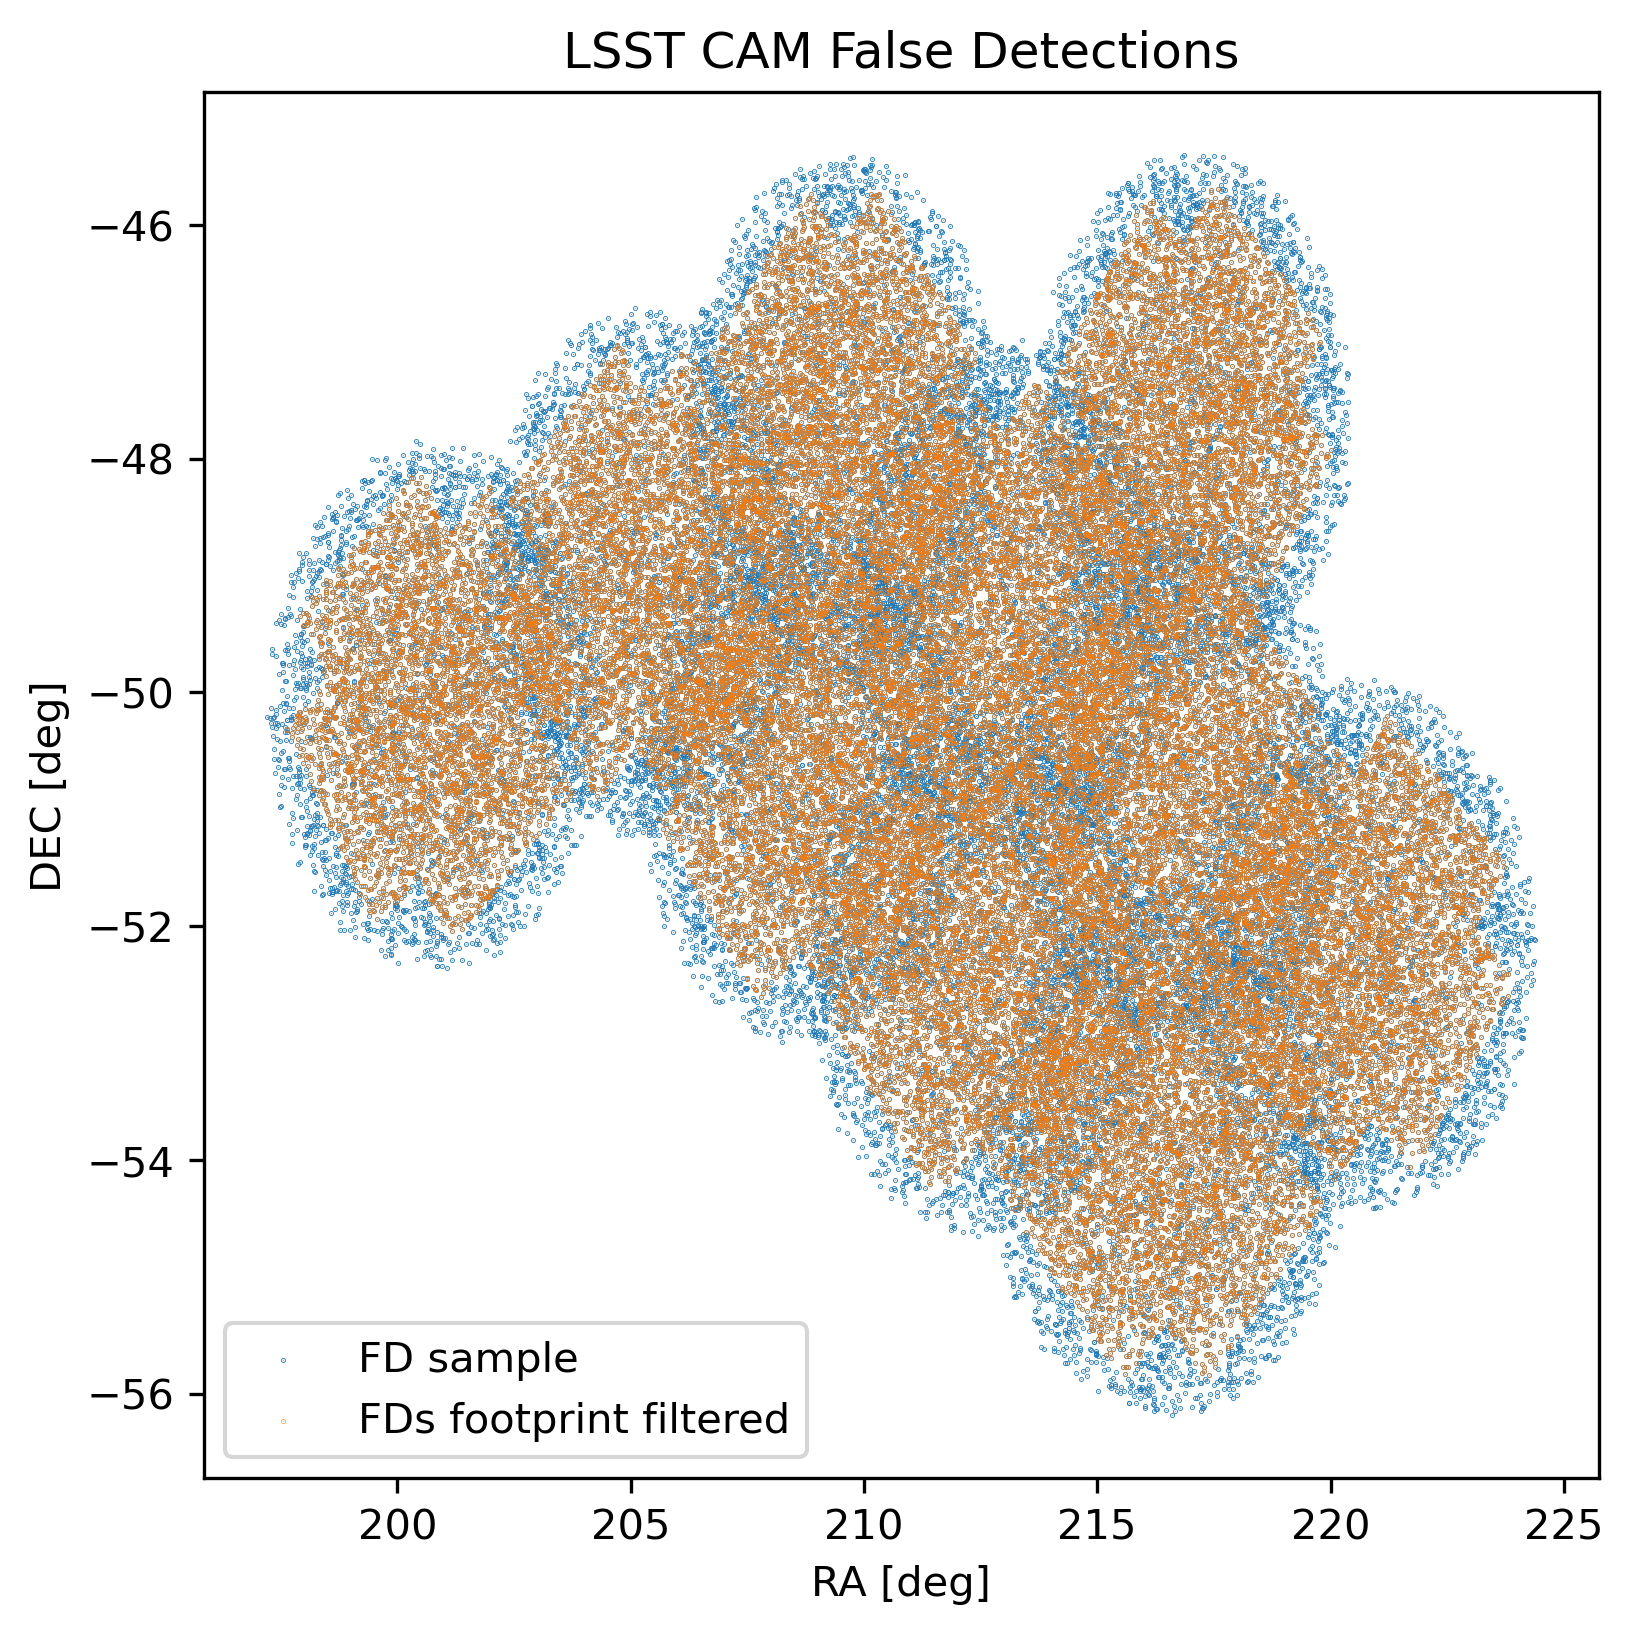

In [65]:
plotFilteredFootprint(FDdf, FDFiltered, raName='AstRA(deg)', 
                          decName='AstDec(deg)', title='LSST CAM False Detections')


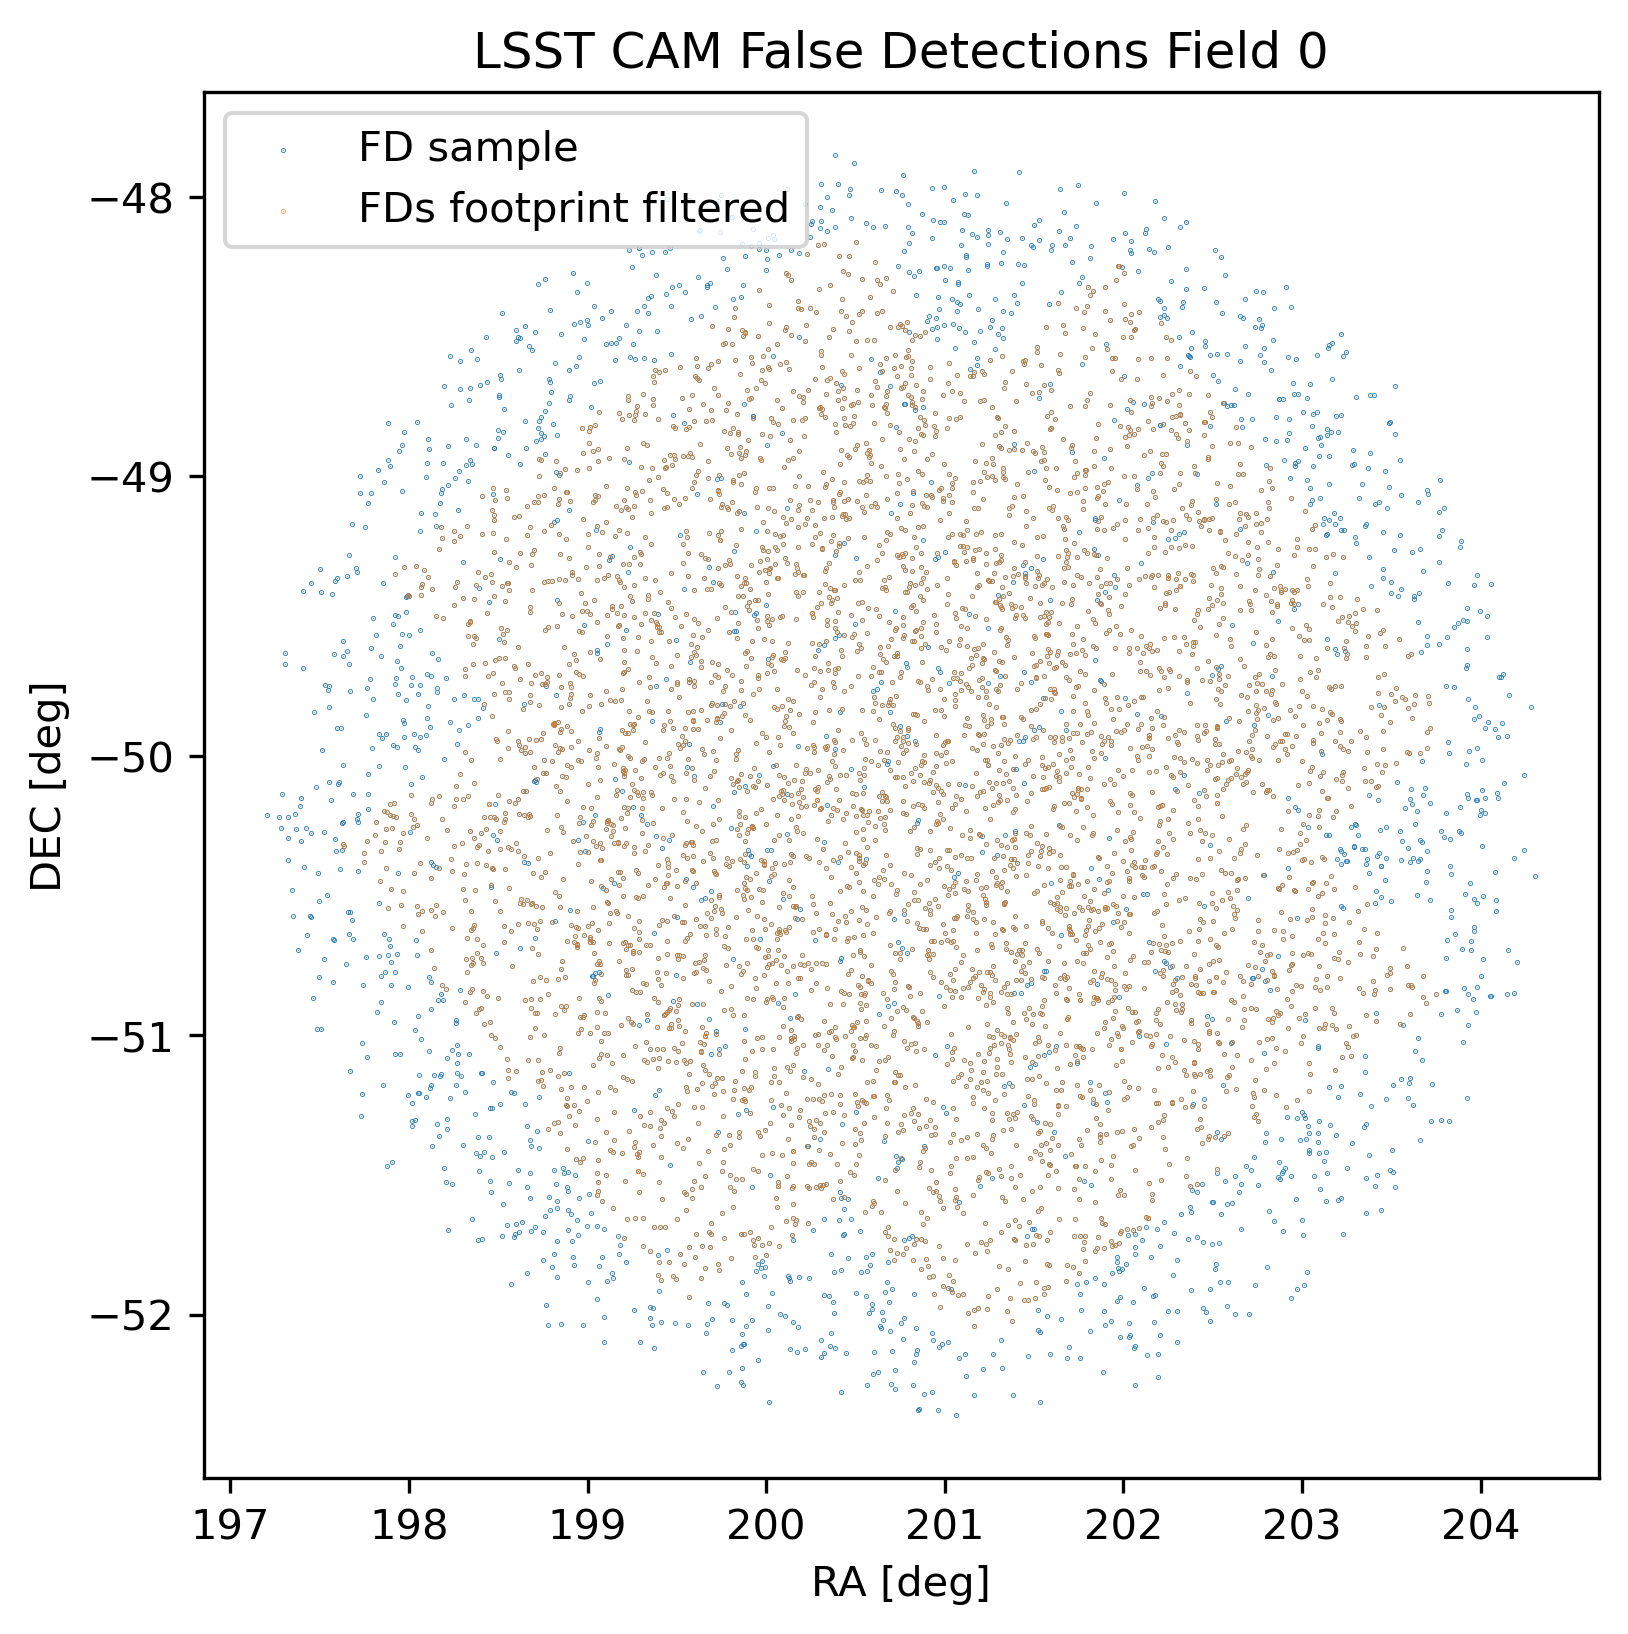

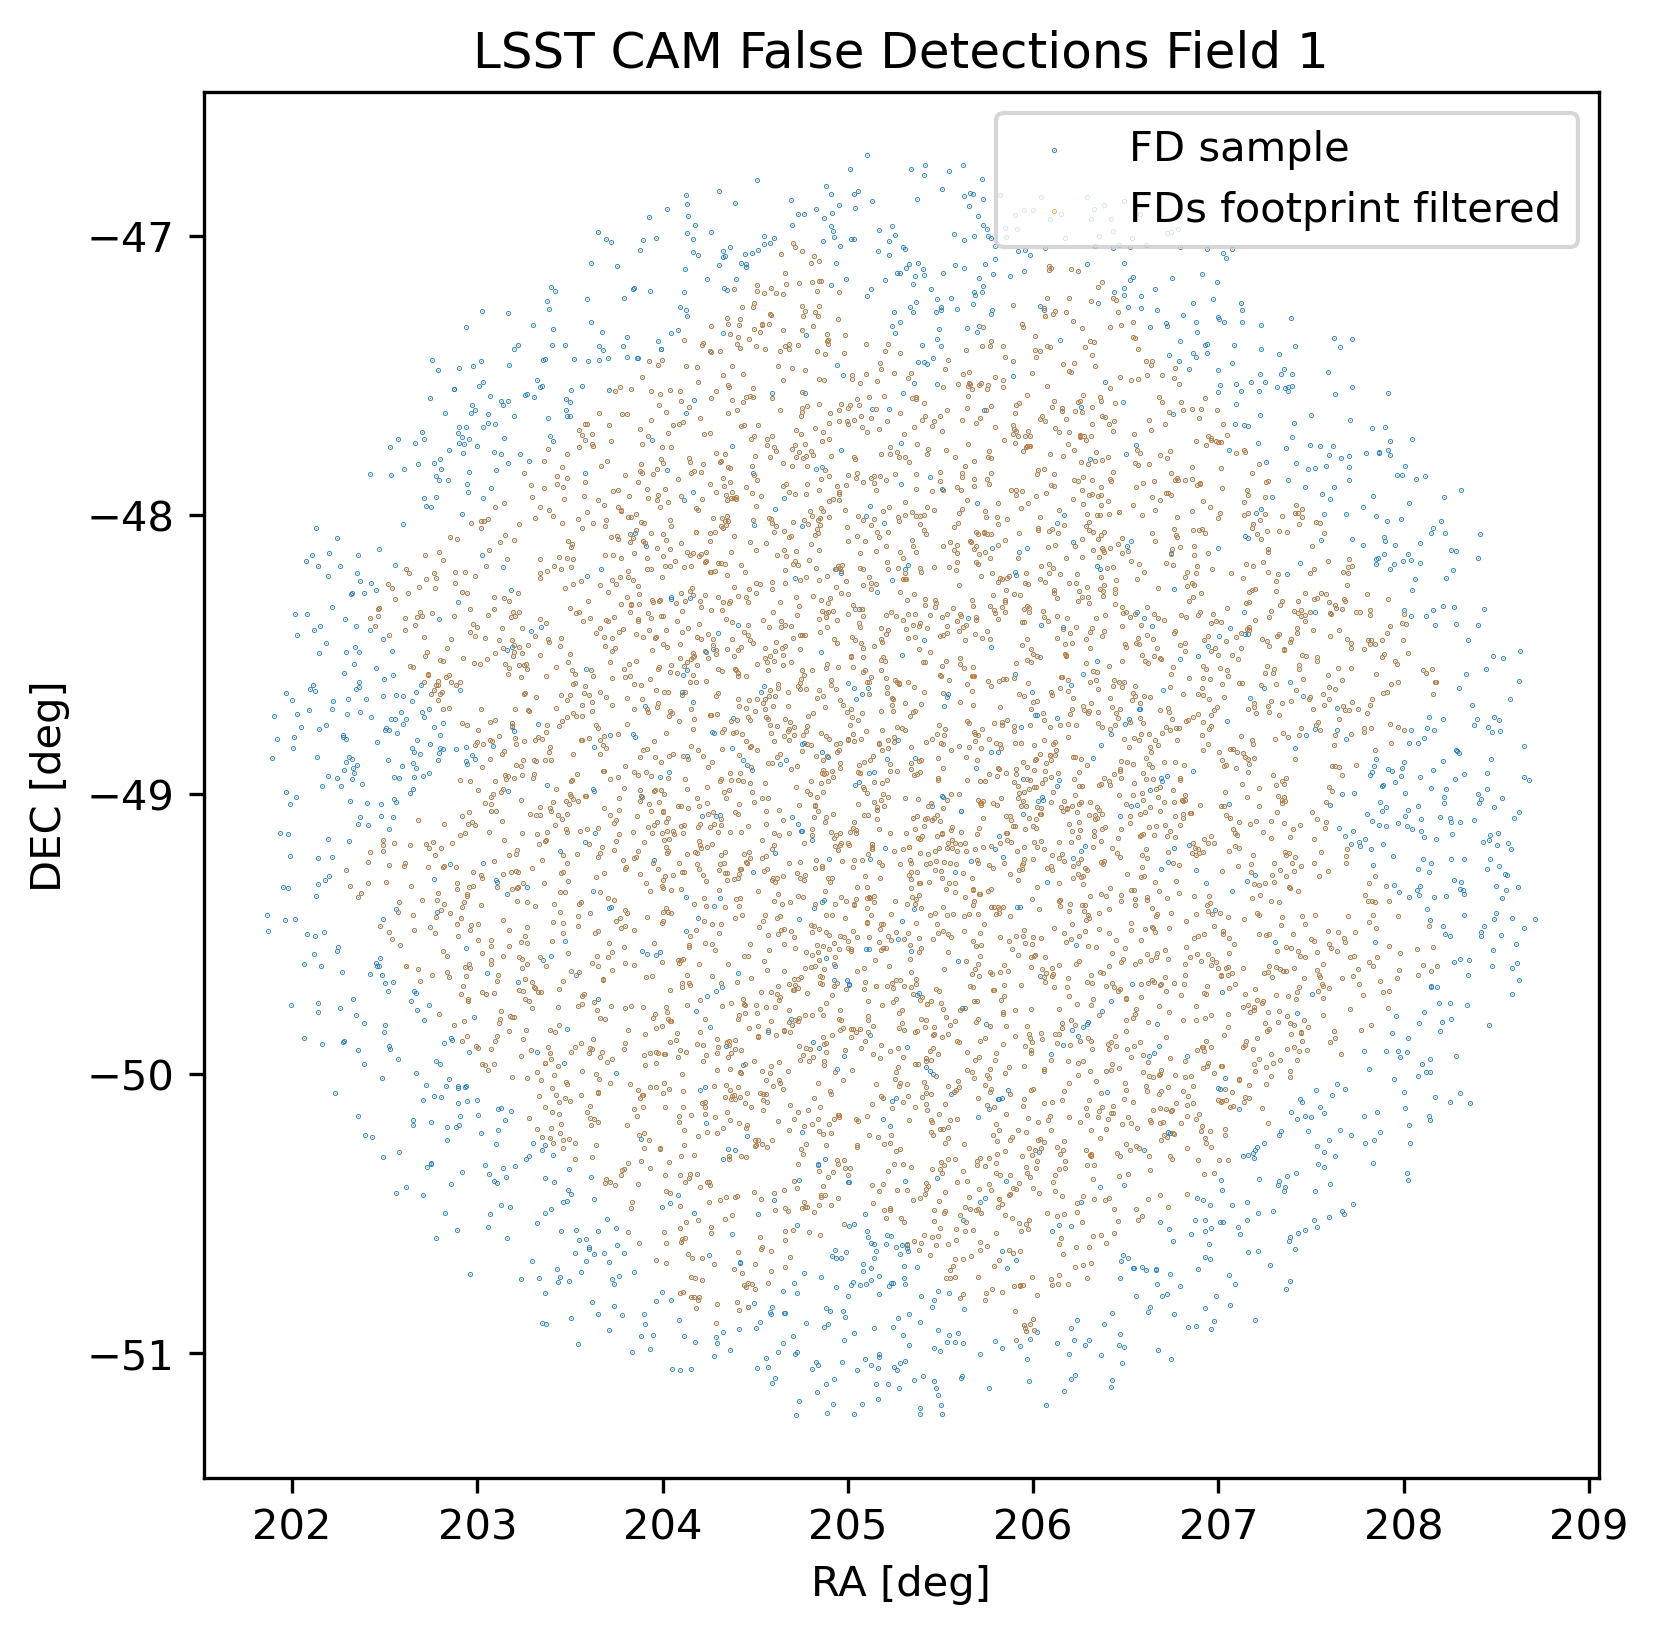

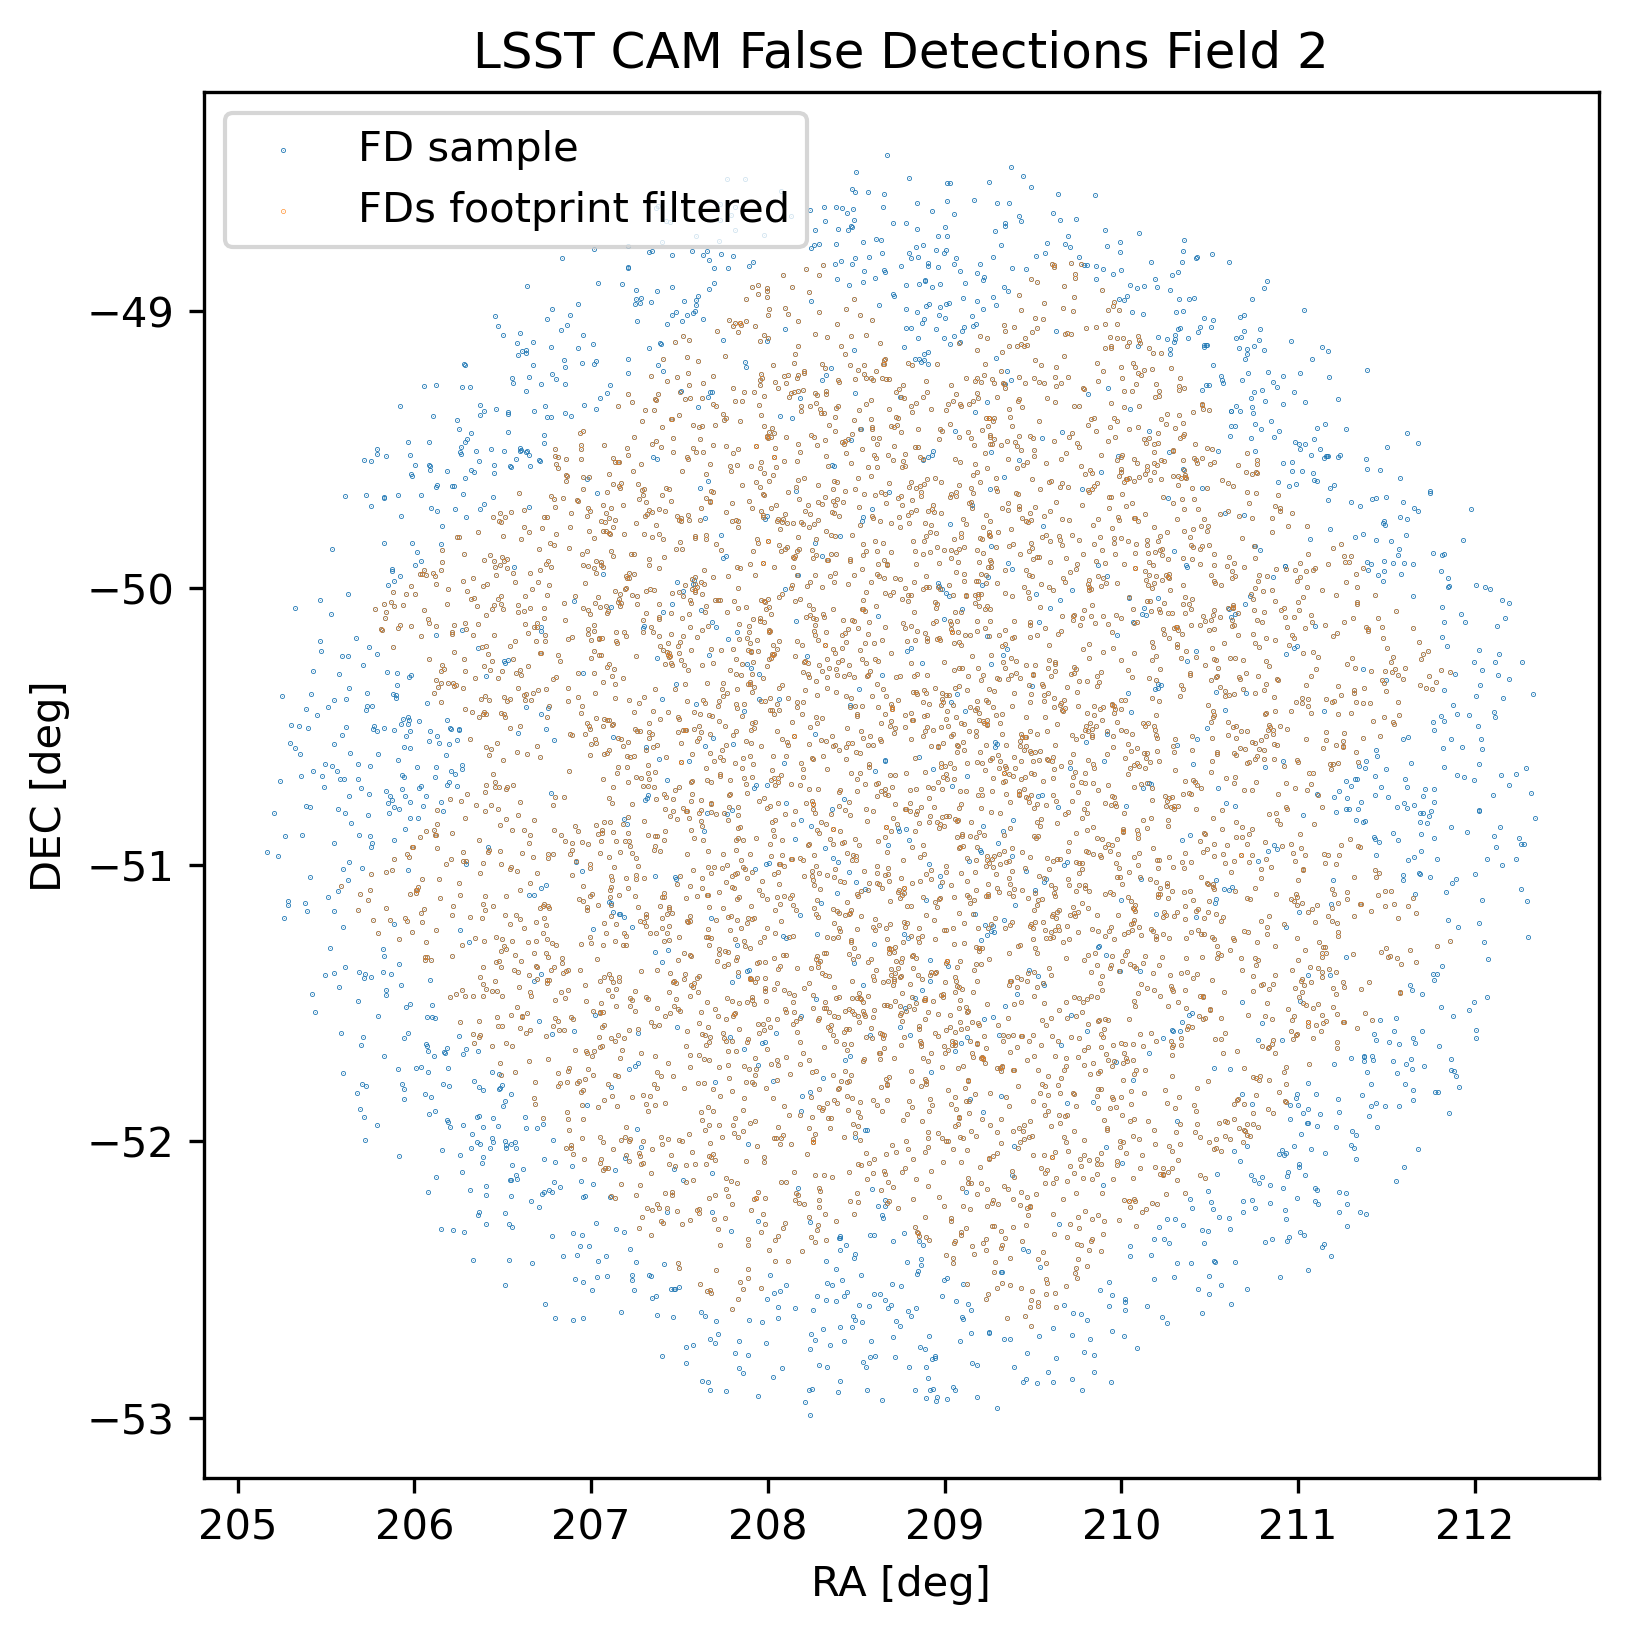

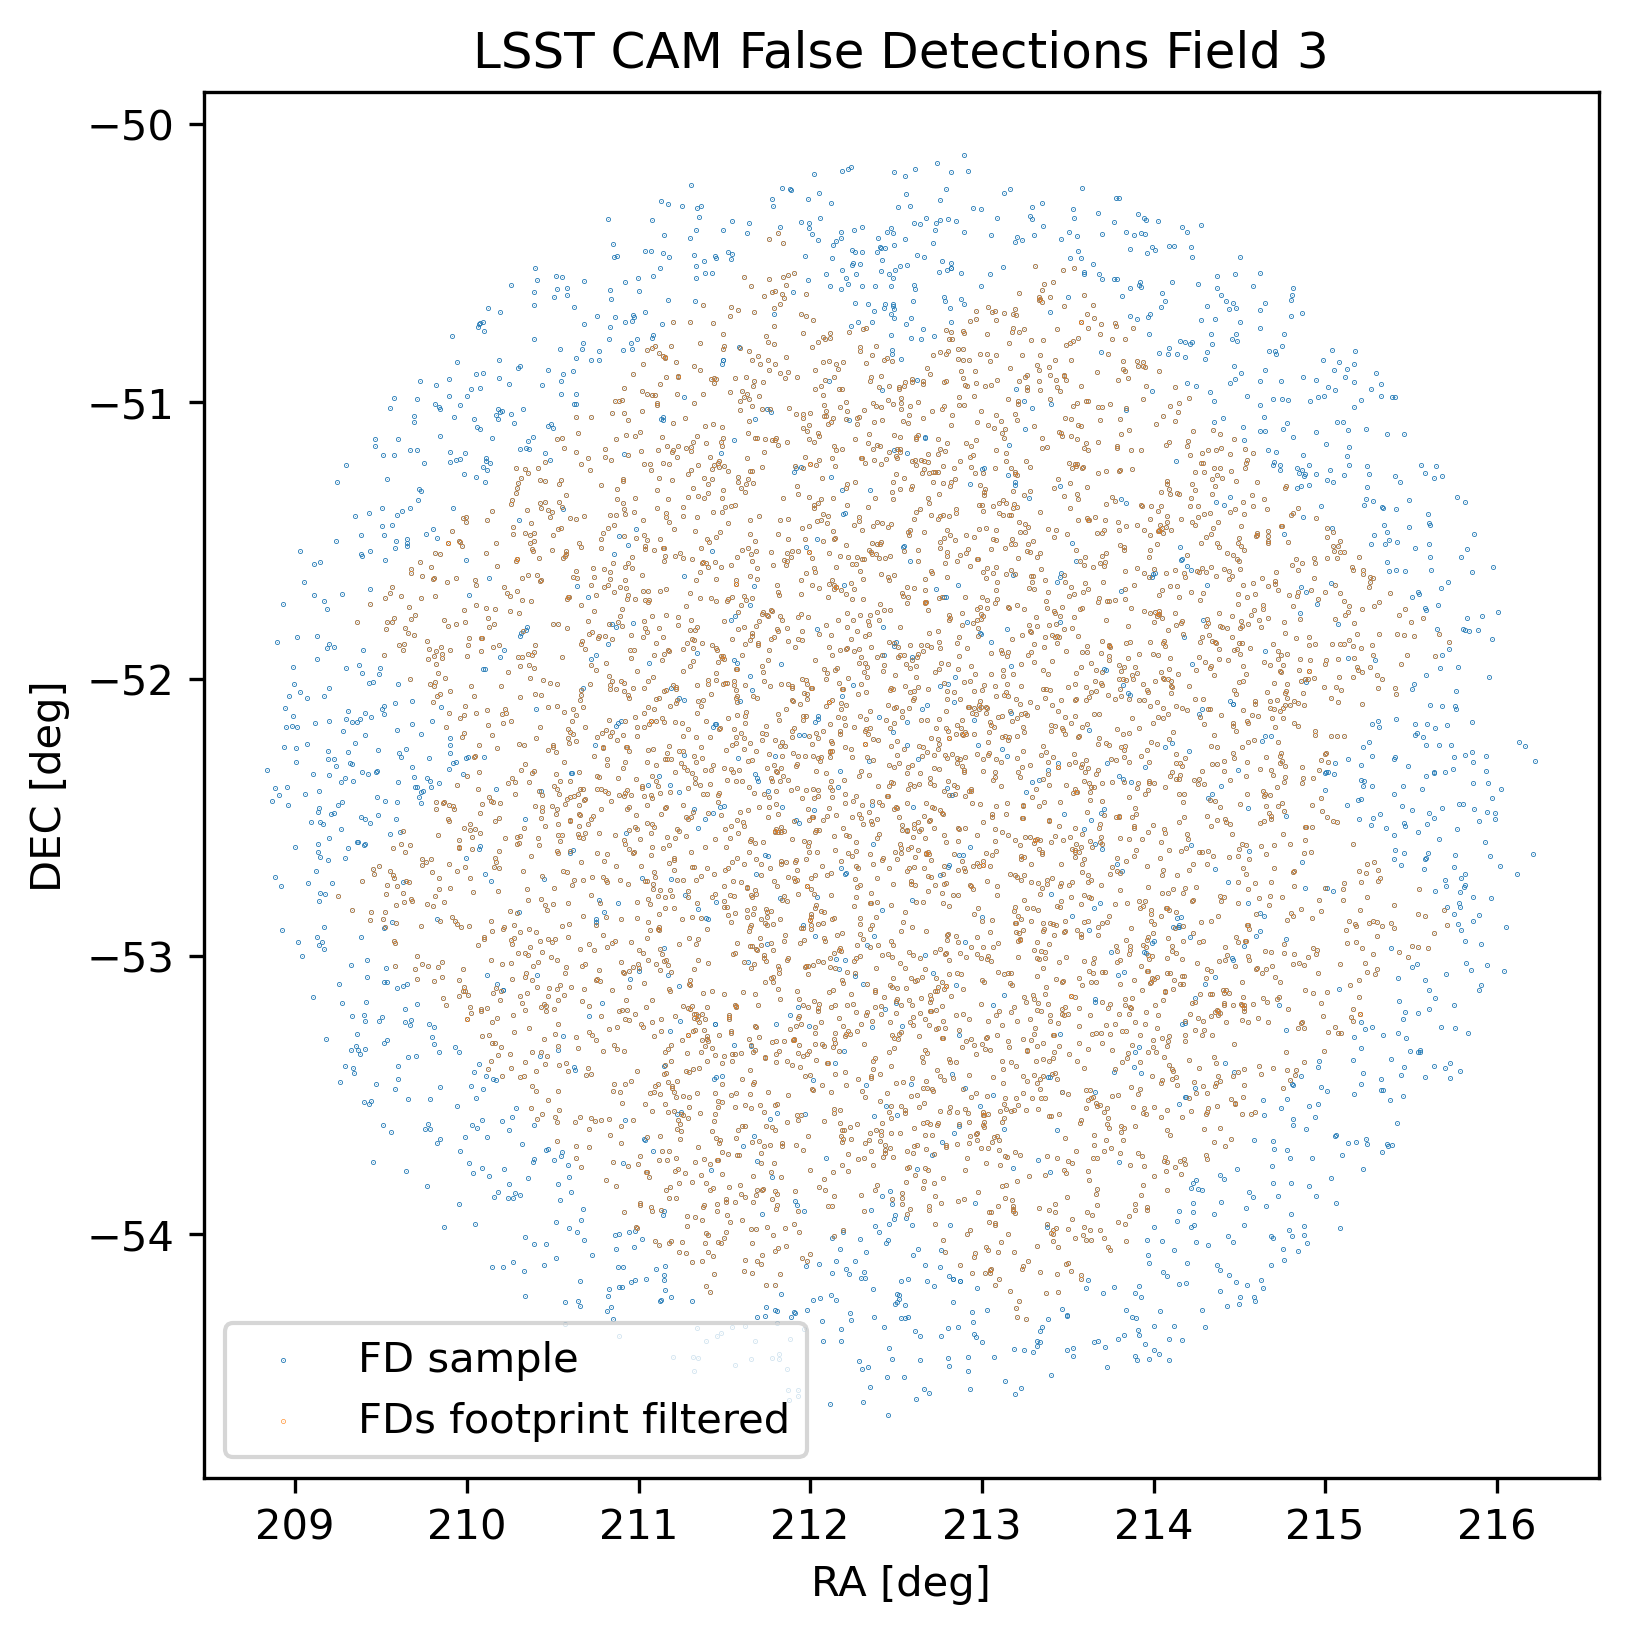

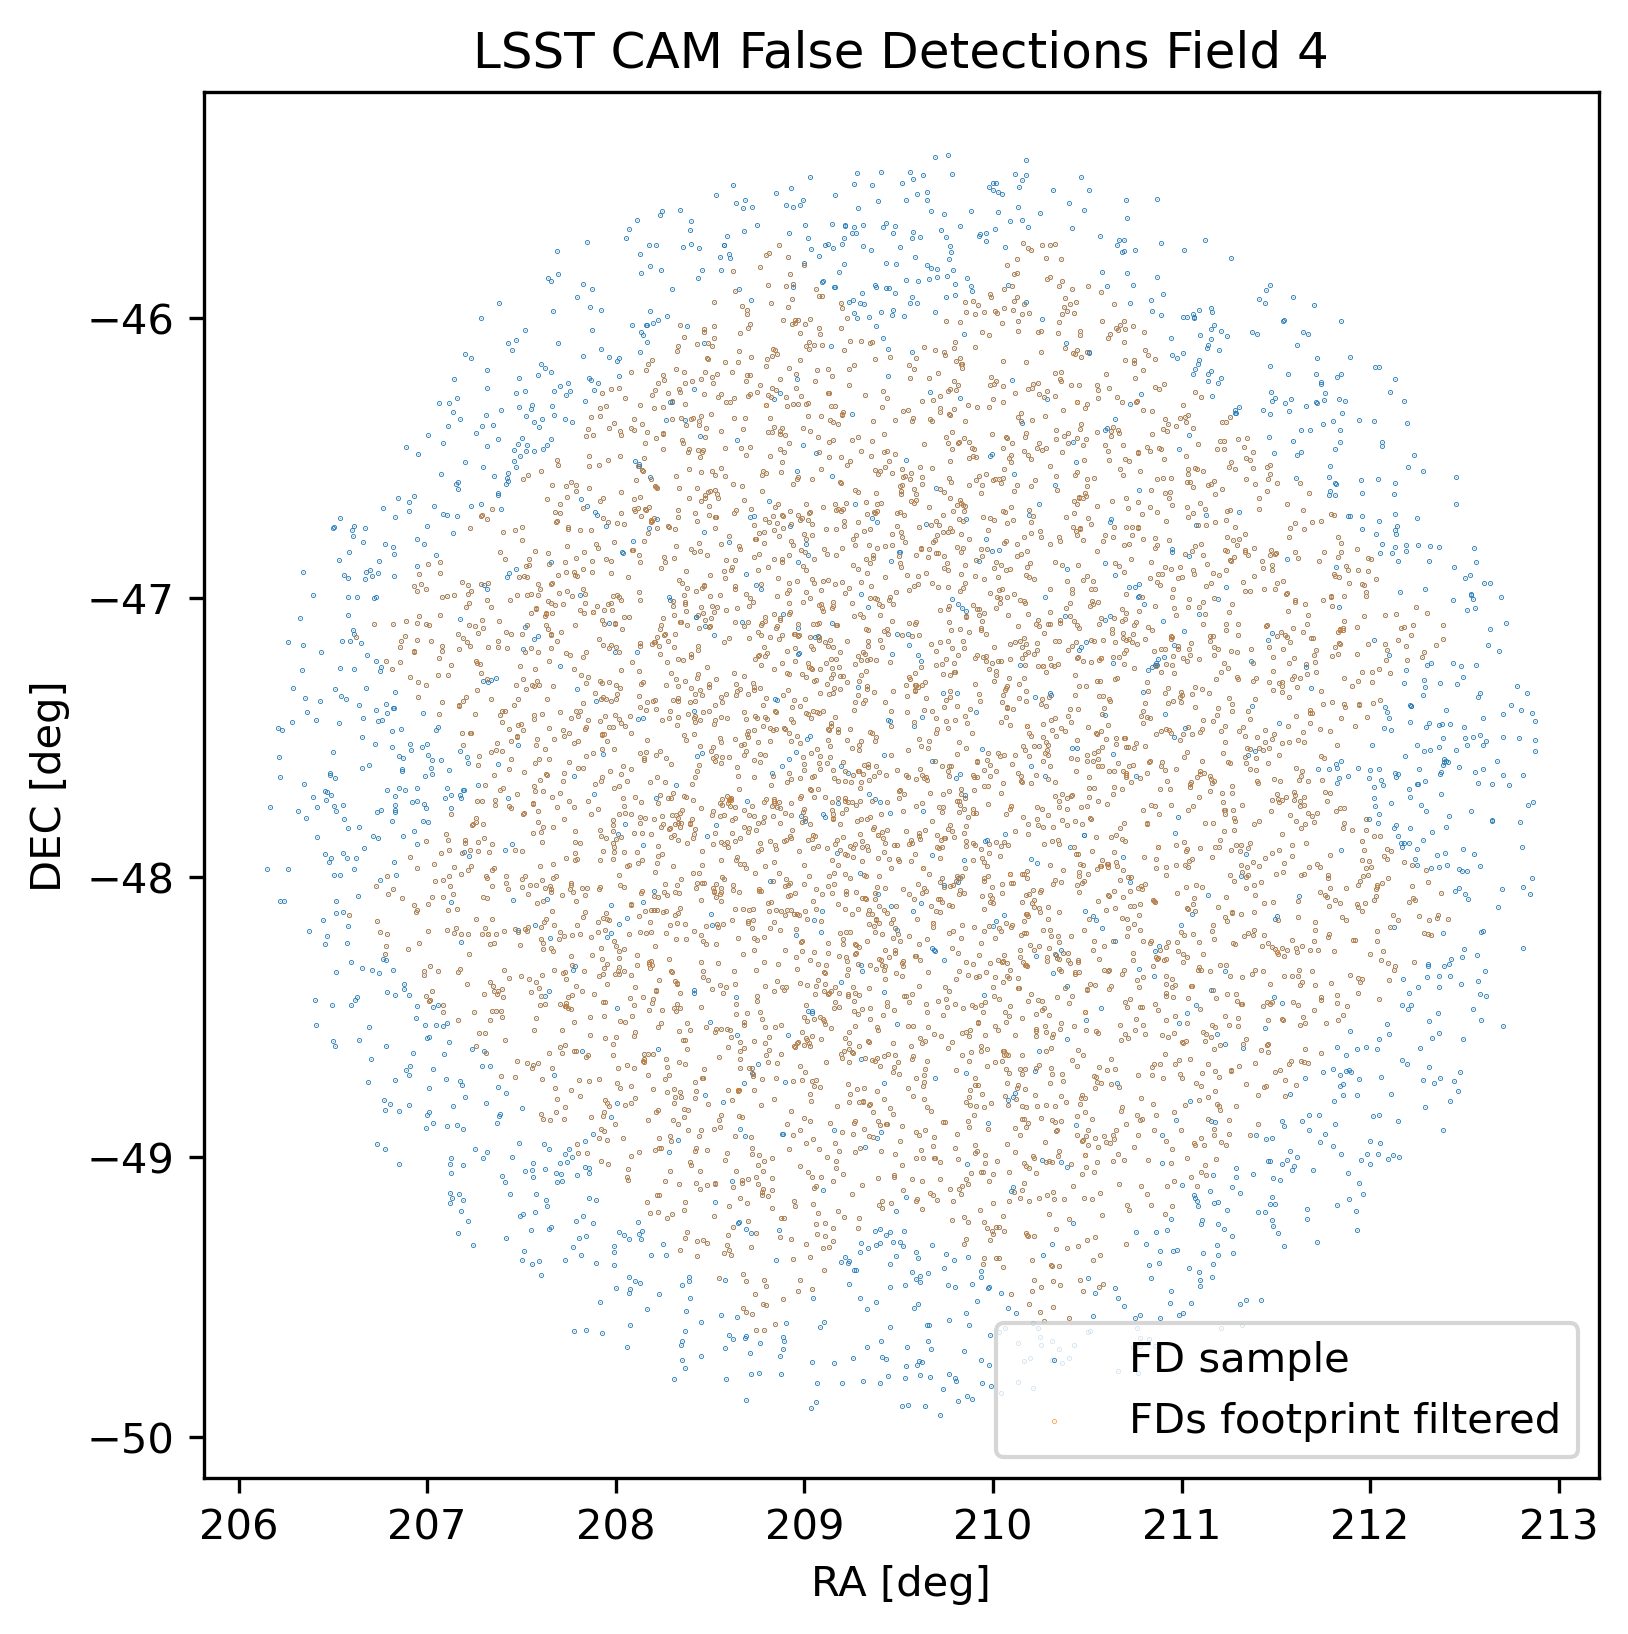

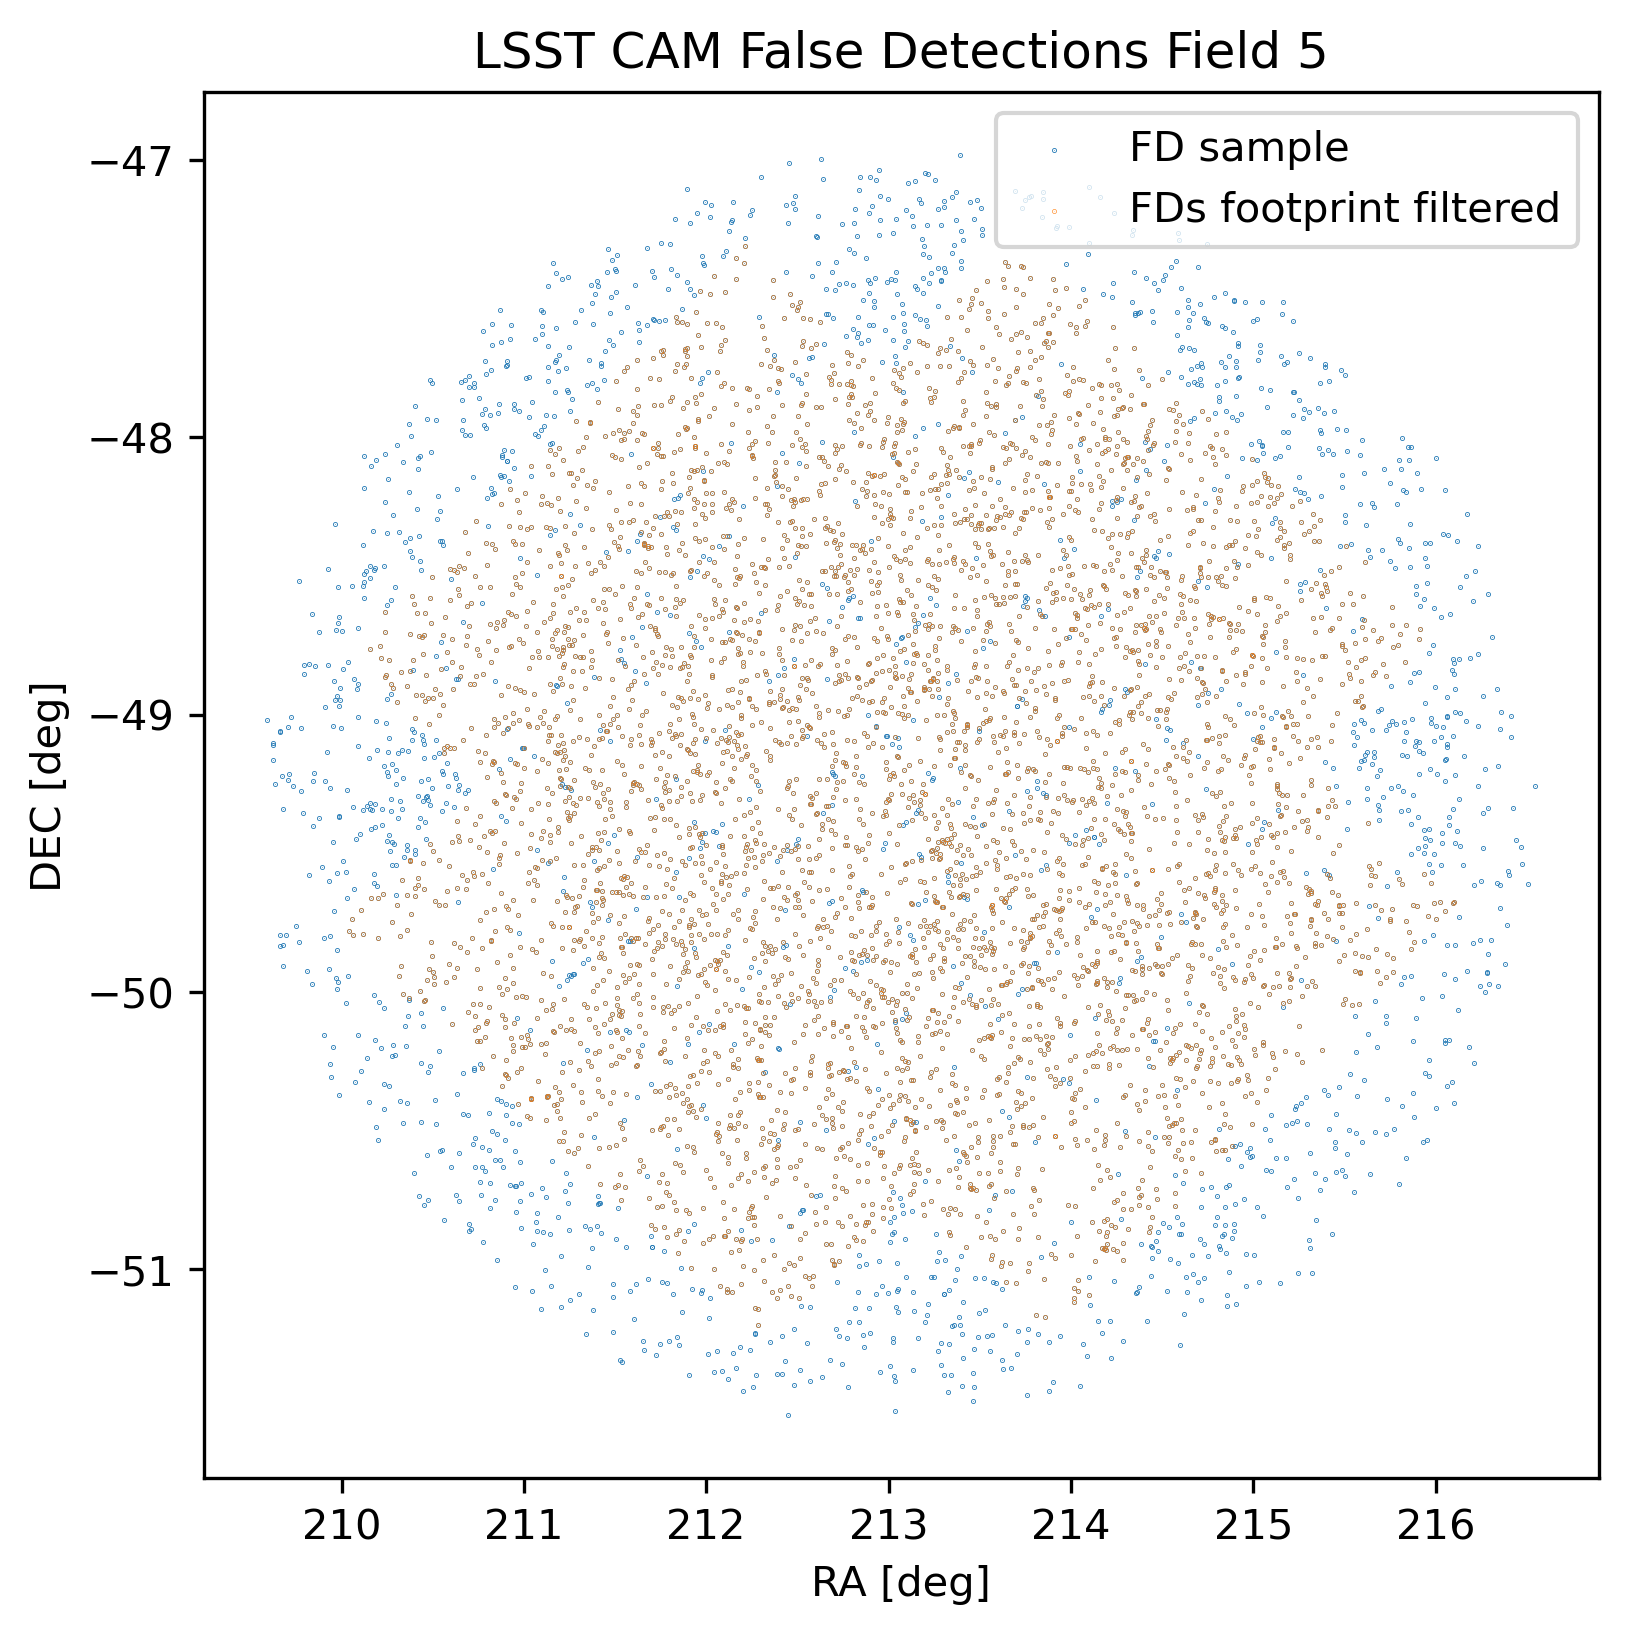

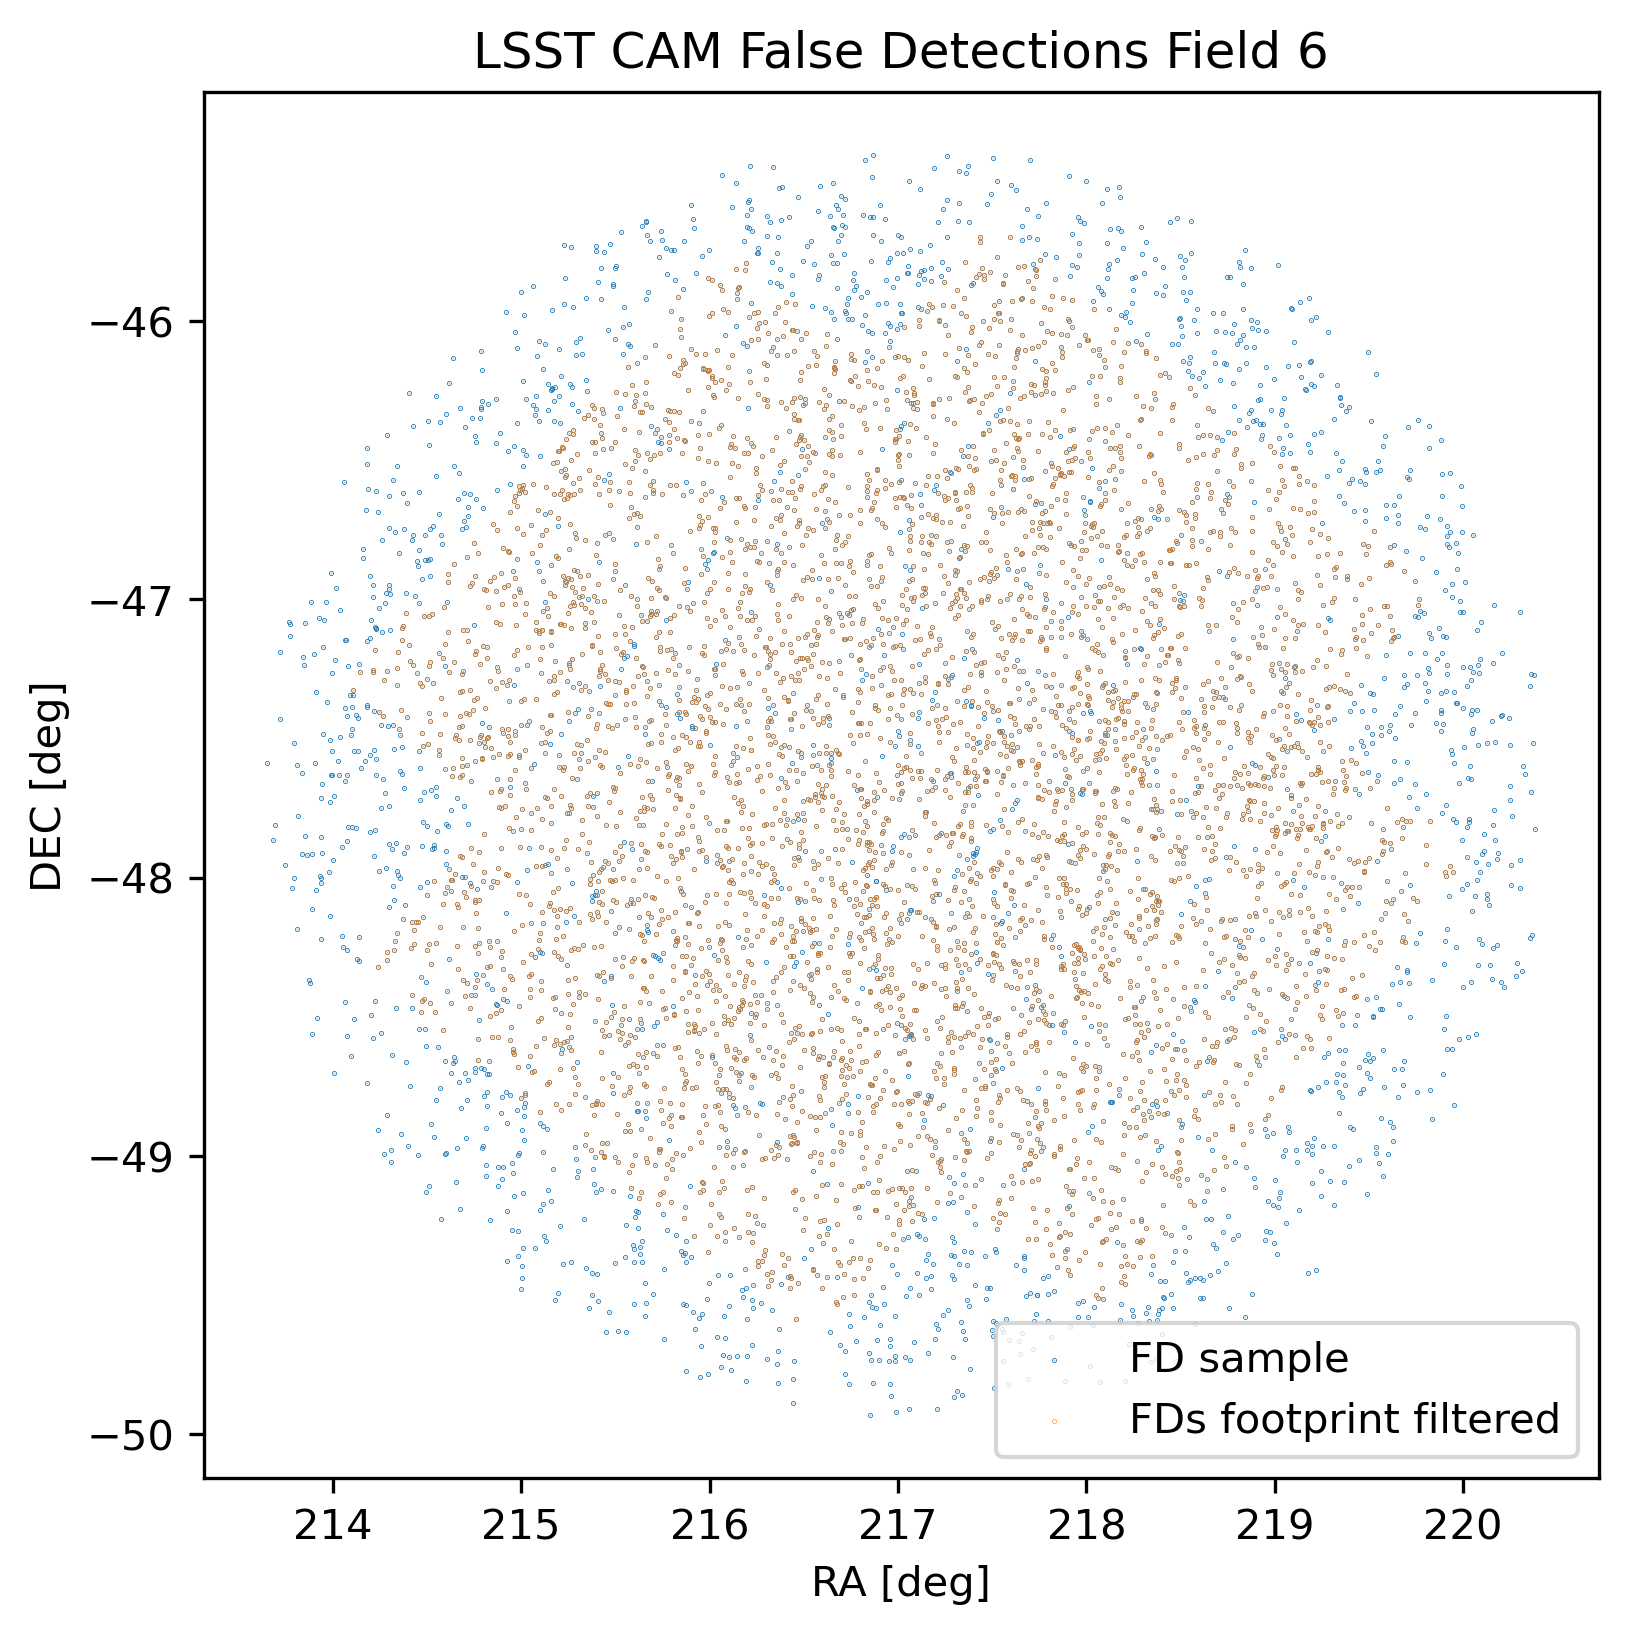

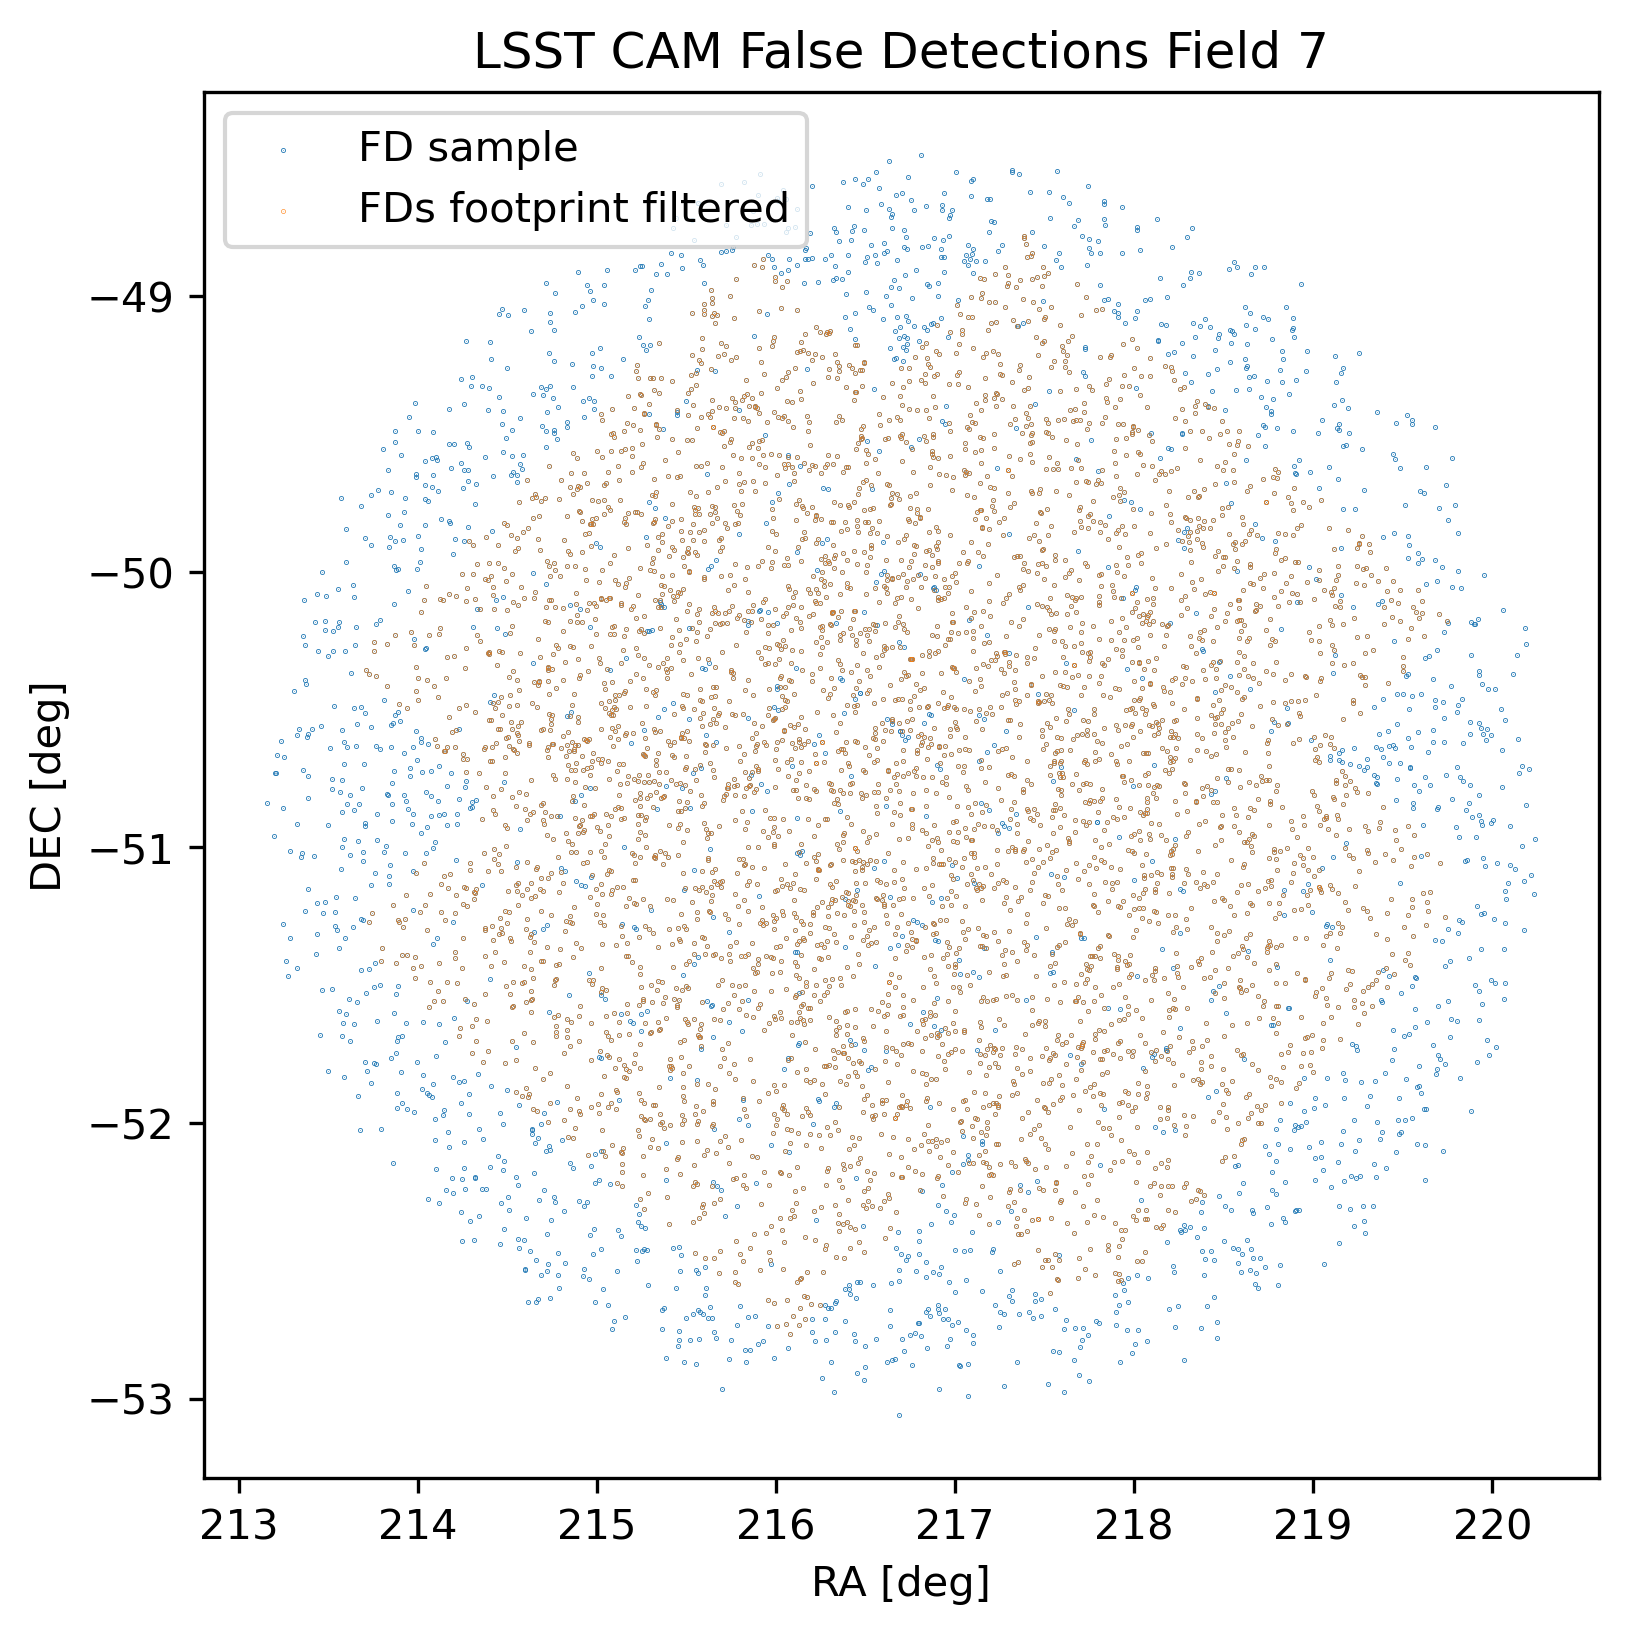

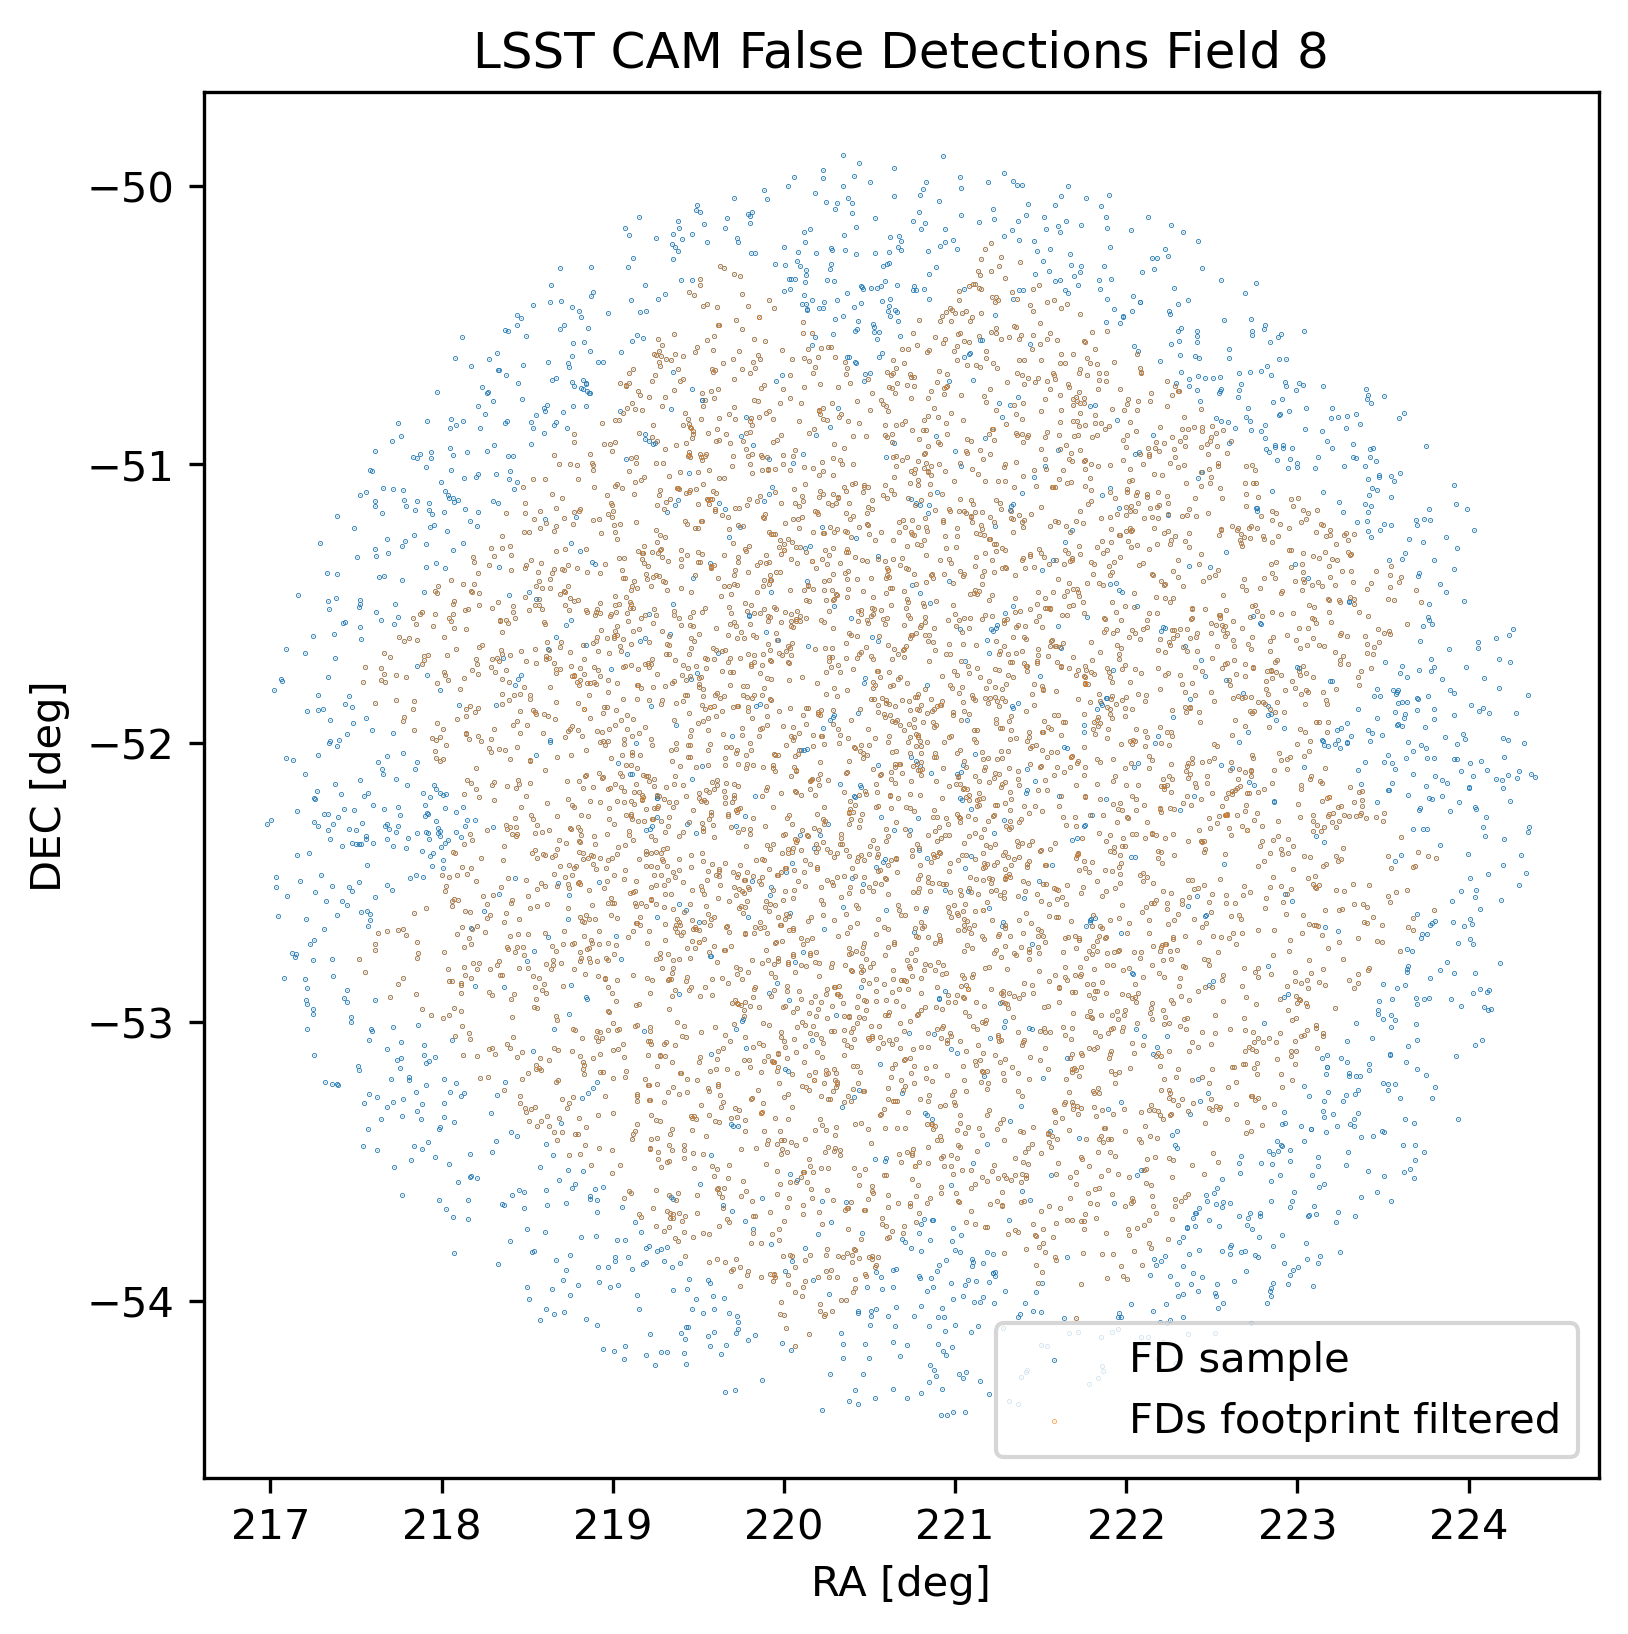

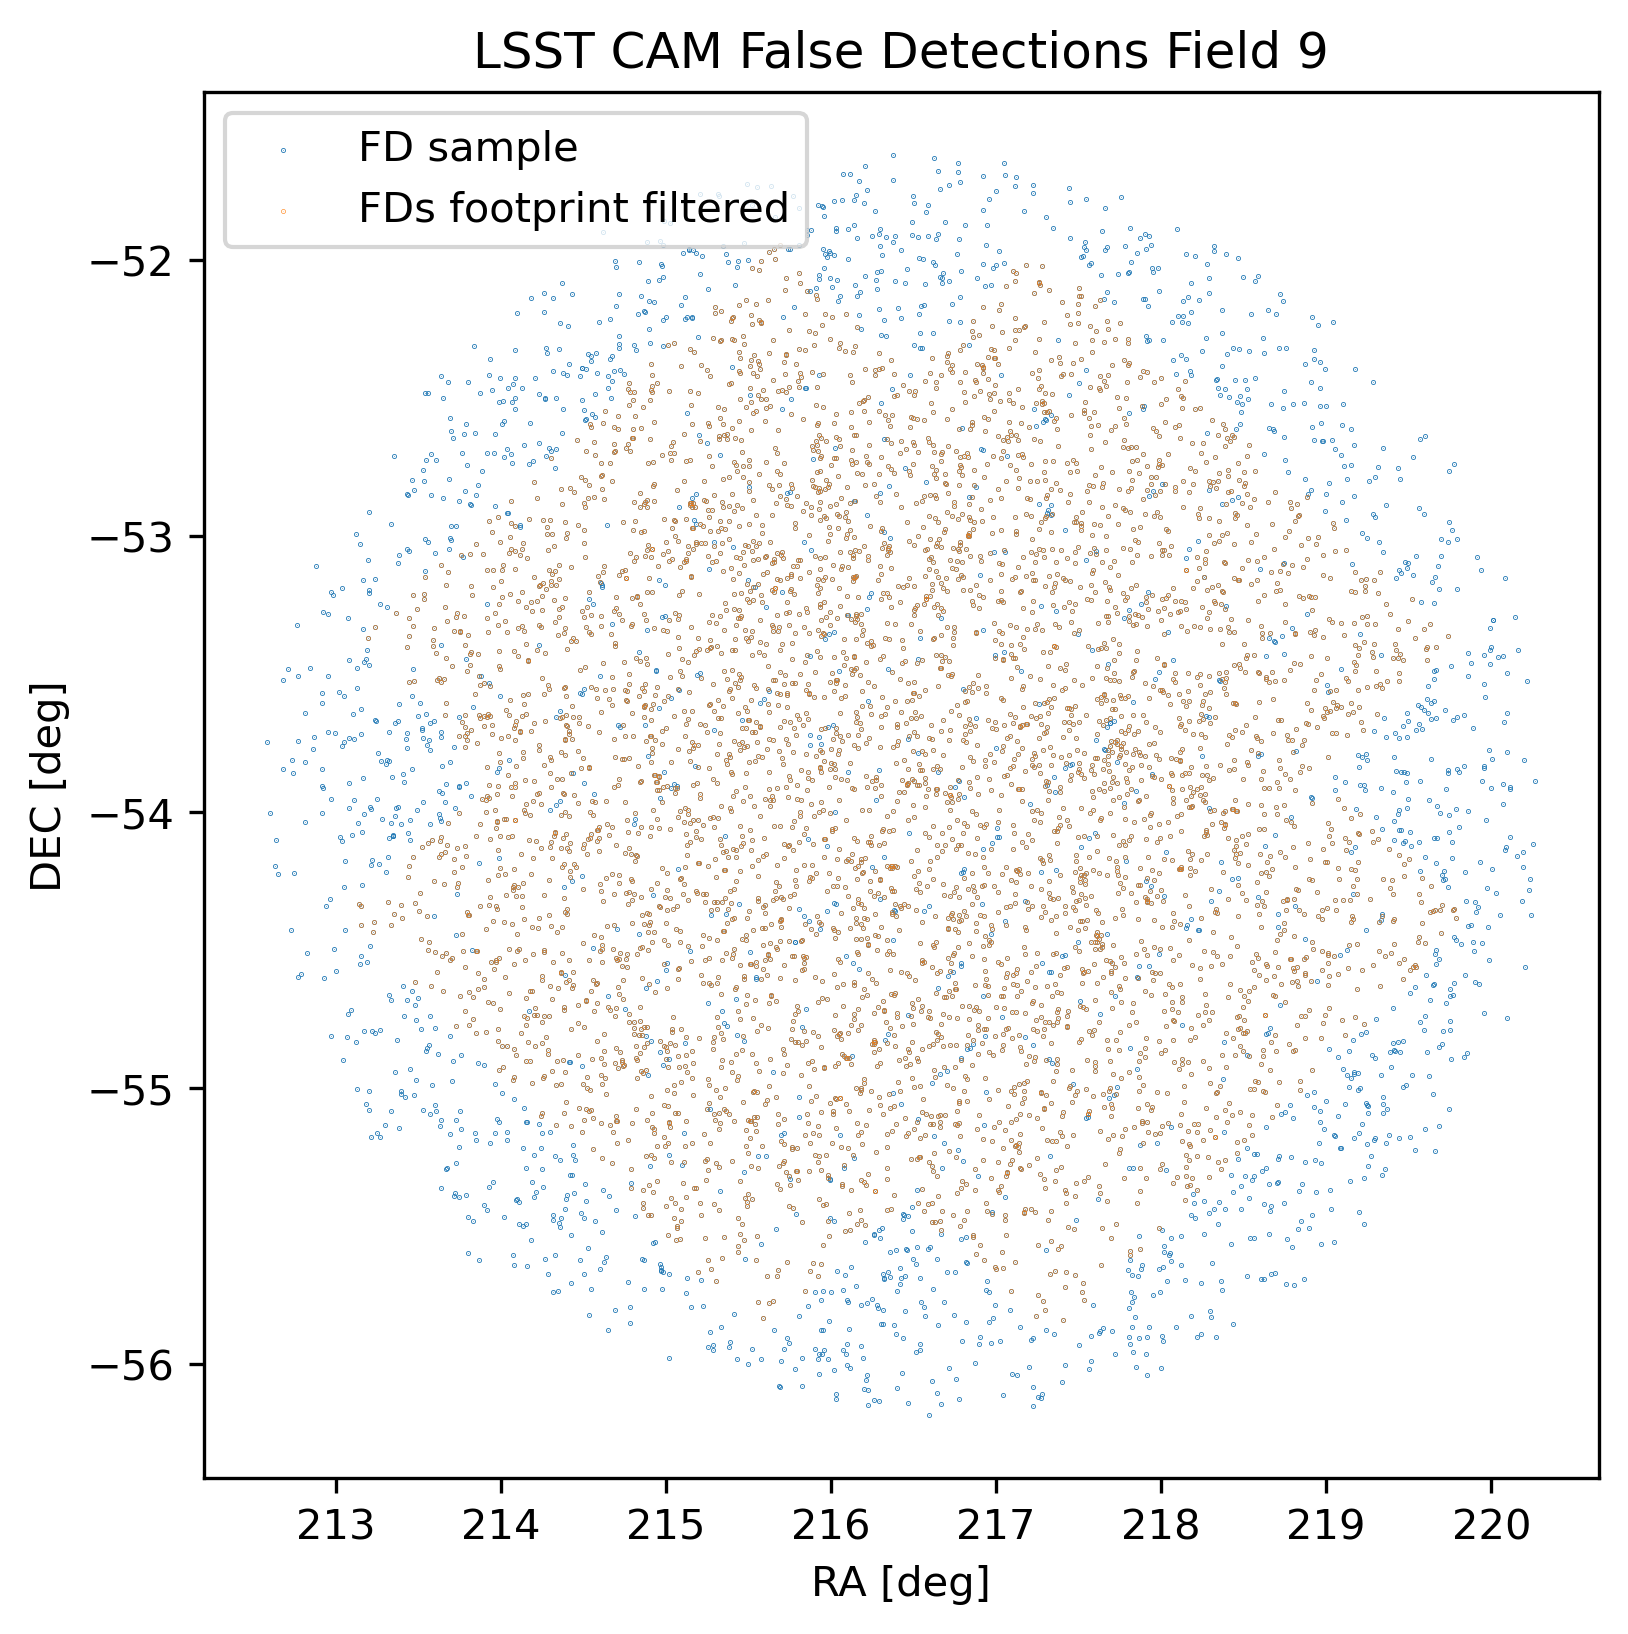

In [66]:
for n in range(10):
    FDF2=FDFiltered[FDFiltered['observationId']==n]
    FDdf2=FDdf[FDdf['observationId']==n]

    plotFilteredFootprint(FDdf2, FDF2, raName='AstRA(deg)', 
                          decName='AstDec(deg)', title='LSST CAM False Detections Field '+str(n))

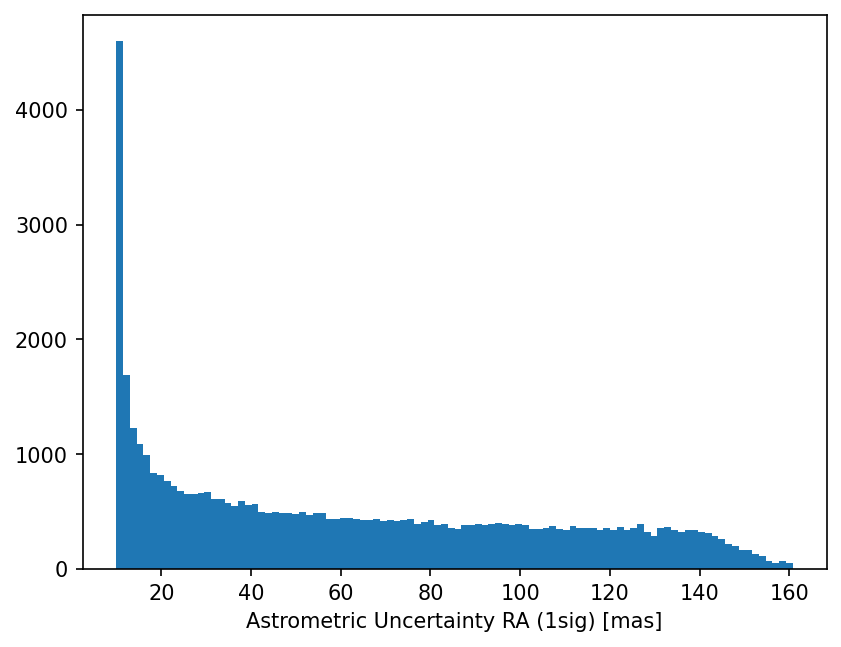

In [67]:
plt.figure(dpi=150)
plt.hist(FDFiltered['AstRASigma(mas)'], bins=100)
plt.xlabel('Astrometric Uncertainty RA (1sig) [mas]')
plt.show()

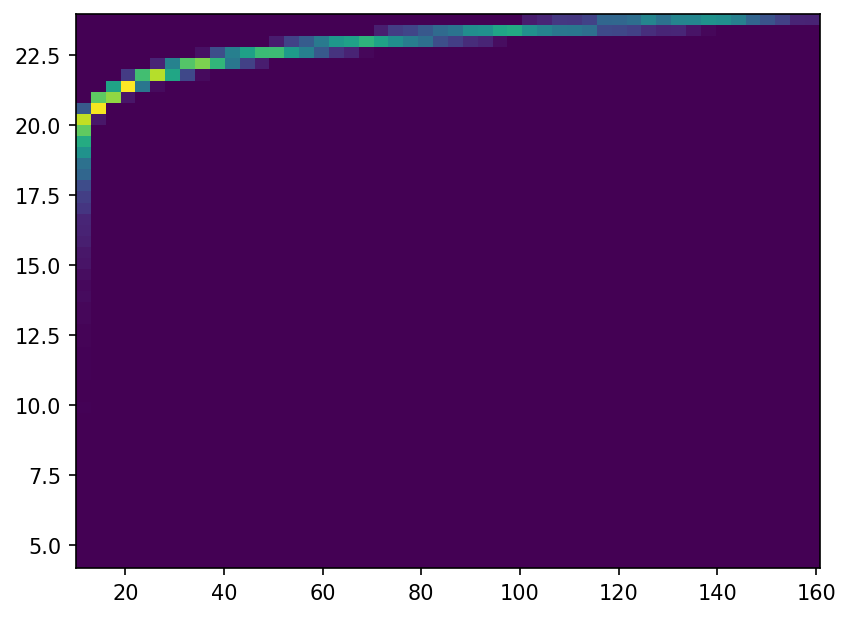

In [68]:
plt.figure(dpi=150)
plt.hist2d(FDFiltered['AstRASigma(mas)'], FDFiltered['Filtermag'], bins=50) 
plt.show()

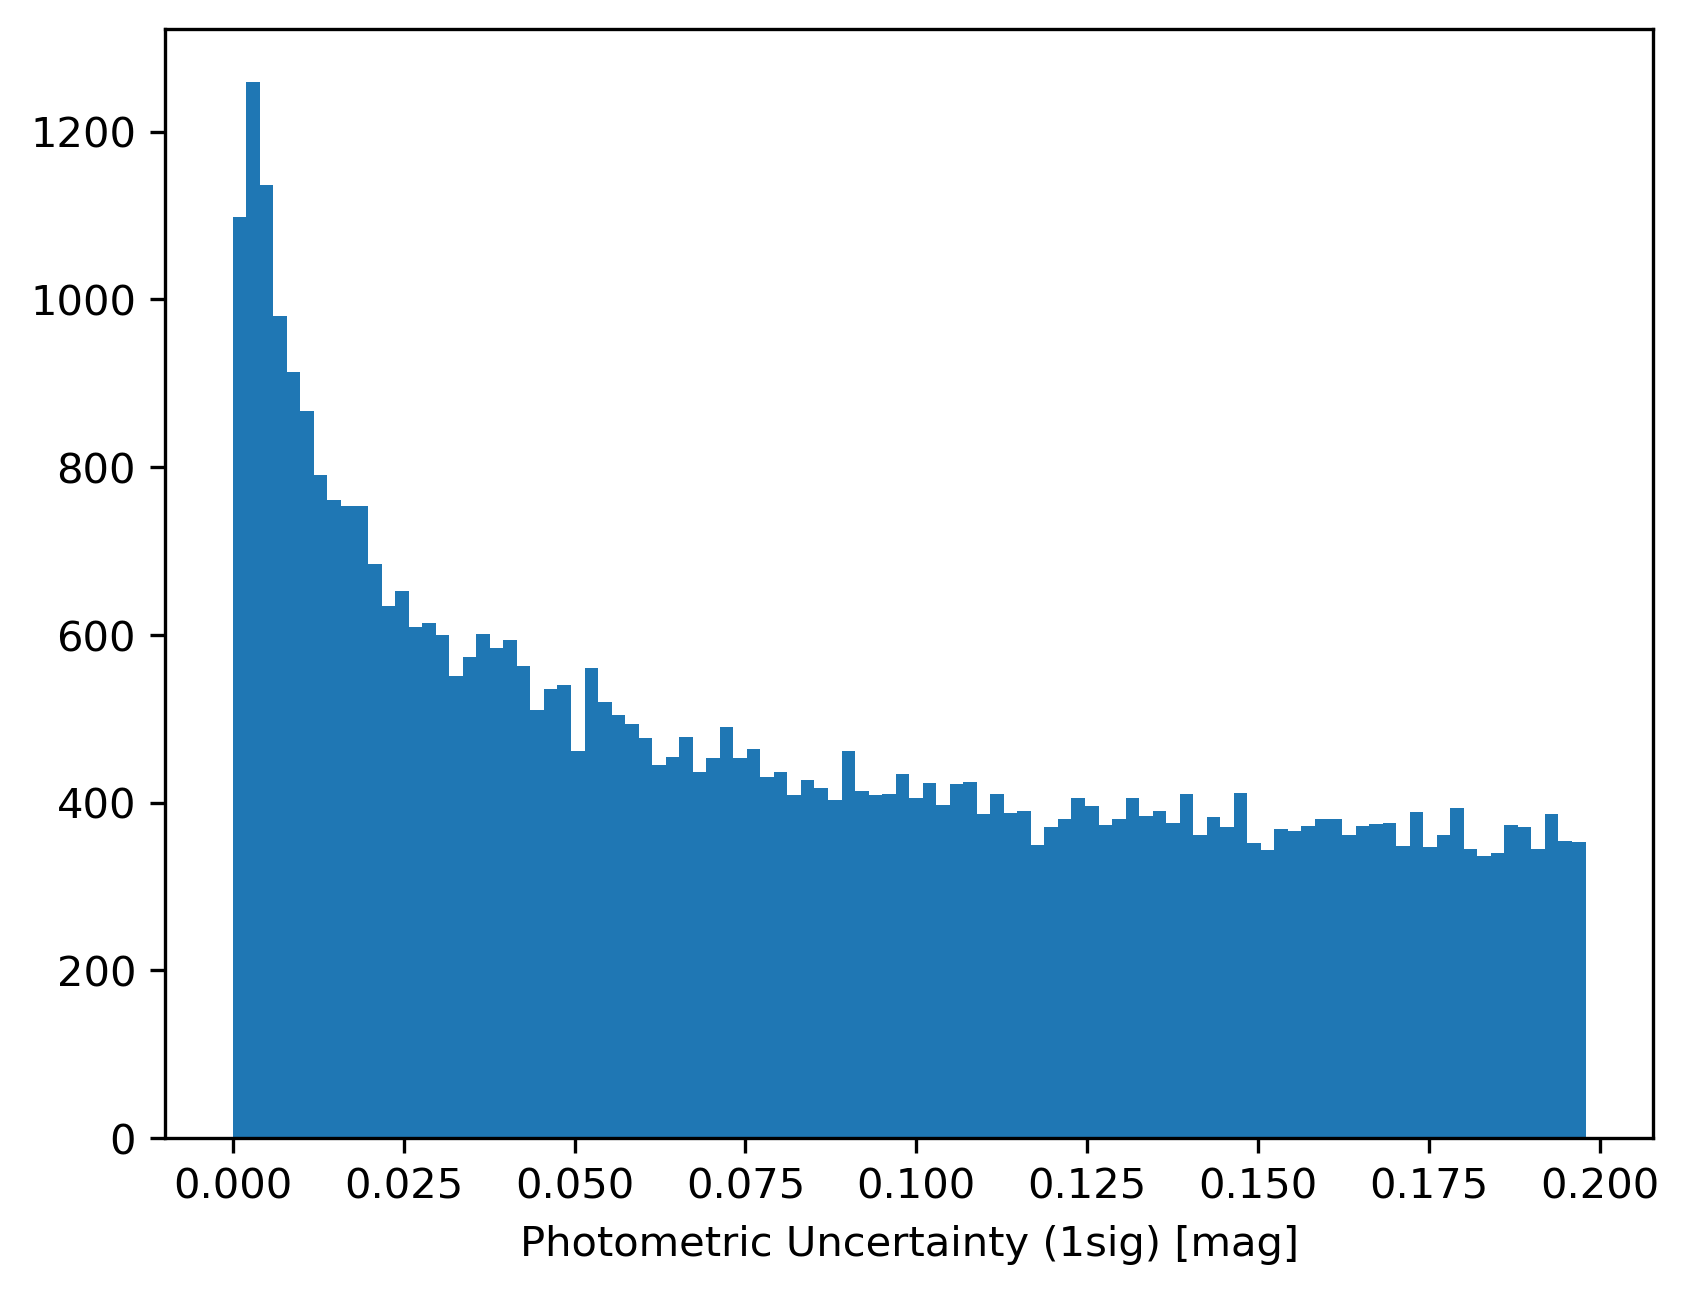

In [69]:
plt.figure(dpi=300)
plt.hist(FDFiltered['PhotometricSigma(mag)'], bins=100)
plt.xlabel('Photometric Uncertainty (1sig) [mag]')
plt.show()

In [72]:
NSdf, nNSlist=createRandomNoise(LSSTdf)
NSdf_copy = pd.merge( NSdf, LSSTdf, 
                        how='left', 
                        left_on='observationId',
                        right_on='observationId',
                        )

ObjID  observationId      FieldMJD AstRange(km) AstRangeRate(km/s)  \
963     FD              3  60796.002782          NaN                NaN   
1481    FD              5  60796.003679          NaN                NaN   
1926    FD              7  60796.004574          NaN                NaN   
1945    FD              7  60796.004574          NaN                NaN   
2096    FD              8  60796.005021          NaN                NaN   
...    ...            ...           ...          ...                ...   
157     FD              0  60796.001439          NaN                NaN   
473     FD              1  60796.001888          NaN                NaN   
872     FD              3  60796.002782          NaN                NaN   
1201    FD              4  60796.003233          NaN                NaN   
1494    FD              5  60796.003679          NaN                NaN   

      AstRA(deg) AstRARate(deg/day)  AstDec(deg) AstDecRate(deg/day)  \
963   215.528169                NaN   -51.994337                 NaN   
1481  215.746129                NaN   -48.639531                 NaN   
1926  219.790939                NaN   -50.134430                 NaN   
1945  219.681345                NaN   -50.196815                 NaN   
2096  223.619742                NaN   -51.589452                 NaN   
...          ...                ...          ...                 ...   
157   197.740951                NaN   -50.409921                 NaN   
473   202.469110                NaN   -49.420141                 NaN   
872   209.333971                NaN   -52.734115                 NaN   
1201  206.663417                NaN   -48.173145                 NaN   
1494  210.256242                NaN   -49.762872                 NaN   

     Ast-Sun(J2000x)(km) Ast-Sun(J2000y)(km) Ast-Sun(J2000z)(km)  \
963                  NaN                 NaN                 NaN   
1481                 NaN                 NaN                 NaN   
1926                 NaN                 NaN                 NaN   
1945                 NaN                 NaN                 NaN   
2096                 NaN                 NaN                 NaN   
...                  ...                 ...                 ...   
157                  NaN                 NaN                 NaN   
473                  NaN                 NaN                 NaN   
872                  NaN                 NaN                 NaN   
1201                 NaN                 NaN                 NaN   
1494                 NaN                 NaN                 NaN   

     Sun-Ast-Obs(deg)    V  Filtermag V(H=0) Filter  AstRASigma(mas)  \
963               NaN  NaN  23.808093    NaN      r       154.291327   
1481              NaN  NaN  23.796203    NaN      r       154.594116   
1926              NaN  NaN  23.746368    NaN      r       158.005290   
1945              NaN  NaN  23.754176    NaN      r       159.126721   
2096              NaN  NaN  23.799132    NaN      r       142.554225   
...               ...  ...        ...    ...    ...              ...   
157               NaN  NaN  23.908288    NaN      r       136.906578   
473               NaN  NaN  23.878397    NaN      r       142.377835   
872               NaN  NaN  23.784185    NaN      r       150.987195   
1201              NaN  NaN  23.844185    NaN      r       149.907539   
1494              NaN  NaN  23.794090    NaN      r       154.298511   

      AstDecSigma(mas)  PhotometricSigma(mag)  
963         154.291327               0.197216  
1481        154.594116               0.197105  
1926        158.005290               0.196074  
1945        159.126721               0.197352  
2096        142.554225               0.193639  
...                ...                    ...  
157         136.906578               0.189550  
473         142.377835               0.192105  
872         150.987195               0.193330  
1201        149.907539               0.196303  
1494        154.298511       

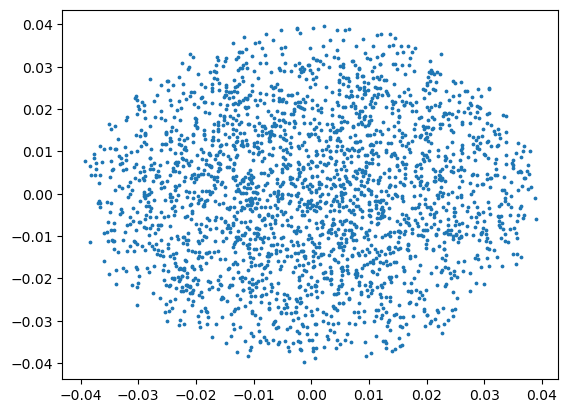

In [74]:
# NSFiltered=cameraFootprintFilter(NSdf,LSSTdf,raname='fieldRA',decname='fieldDec',obsIdname='observationId', 
#                    obsepochname='observationStartMJD',rotskyname='rotSkyPos')
NS_detected_idxs, _ = camera.applyFootprint( NSdf_copy )
NSFiltered=NSdf.iloc[ NS_detected_idxs ]
NSFiltered

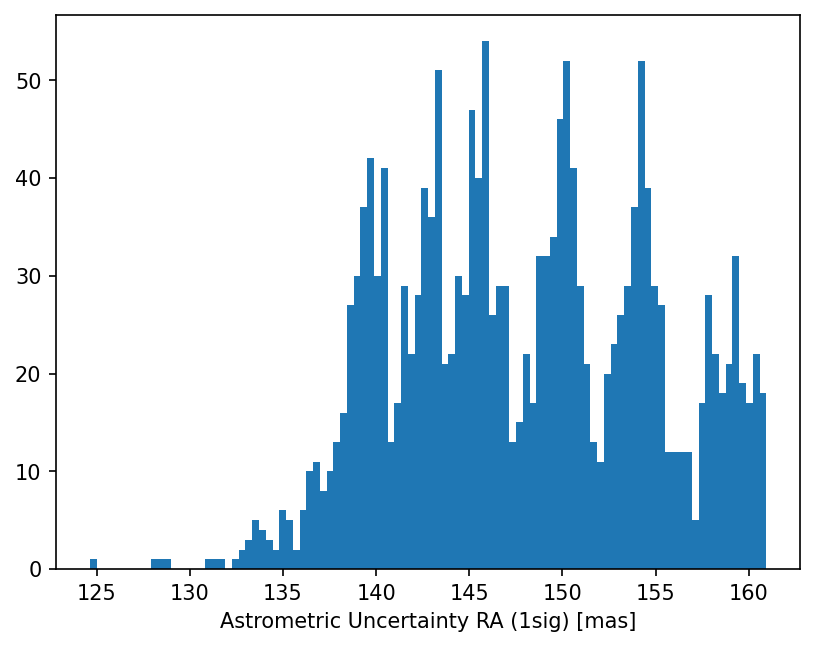

In [75]:
plt.figure(dpi=150)
plt.hist(NSFiltered['AstRASigma(mas)'], bins=100)
plt.xlabel('Astrometric Uncertainty RA (1sig) [mas]')
plt.show()

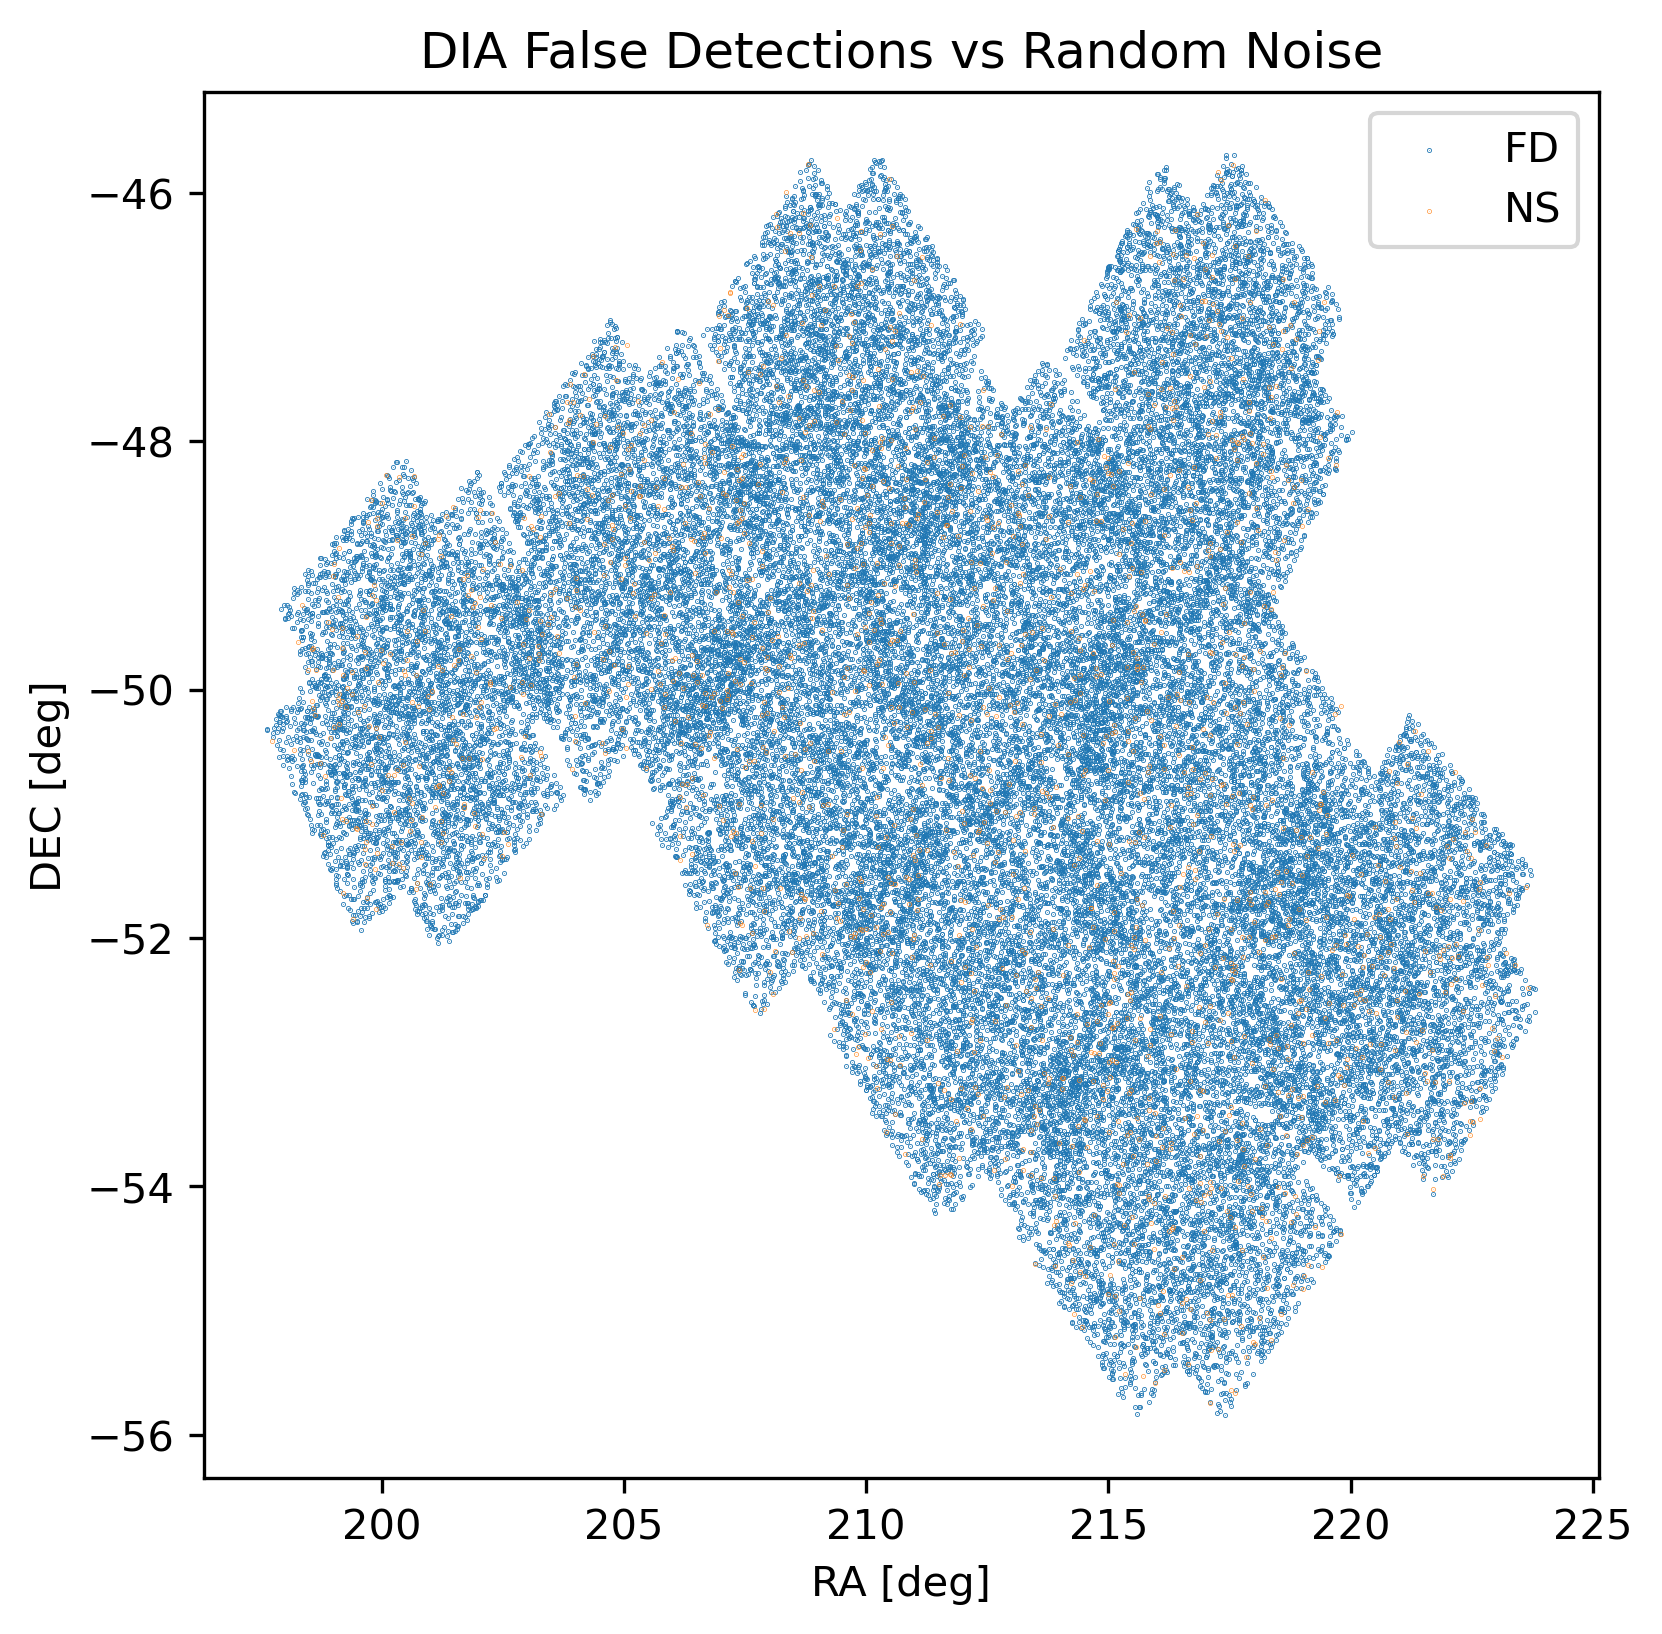

In [76]:
plotFilteredFootprint(FDFiltered, NSFiltered, raName='AstRA(deg)', 
                          decName='AstDec(deg)', title='DIA False Detections vs Random Noise', label1='FD', label2='NS')

### False Detections for LSST year 1


In [ ]:
# select year 1 of LSST opsim
nrows=220000
LSSTdf=getSqlData(db_path,0,nrows)
(LSSTdf.observationStartMJD.max()-LSSTdf.observationStartMJD.min())/365

1.0414905132116448

In [ ]:
delta=500
visit_range=np.arange(0,nrows,delta)

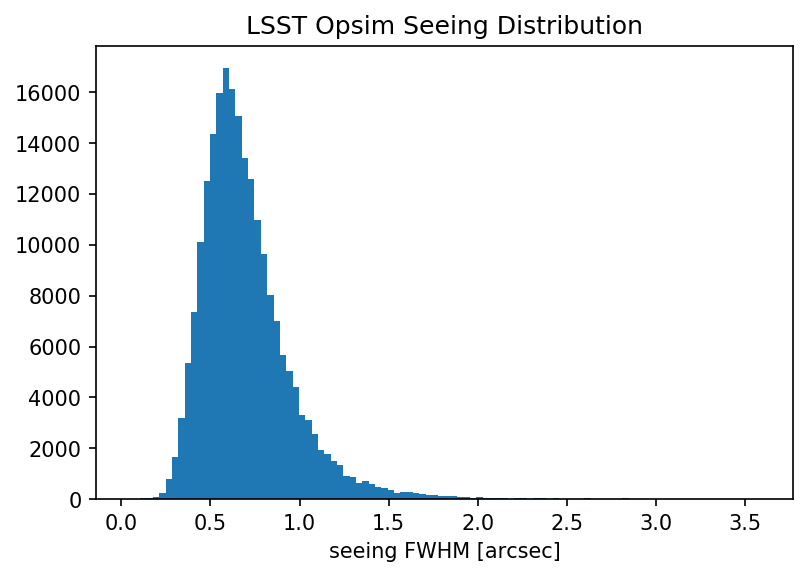

In [ ]:
# Plot the seeing distribution
plt.figure(dpi=150)
plt.title('LSST Opsim Seeing Distribution')
LSSTdf.seeingFwhm500.hist(bins=100)
plt.grid(False)
plt.xlabel('seeing FWHM [arcsec]')
plt.show()

Create DIA False Detection files for the first year of LSST.

In [ ]:
Parallel(n_jobs=10)(delayed(makeFalseDetectionsFiles)(i,delta,db_path, seed=i) for i in visit_range)

/epyc/projects/sssc/conda-sssc-env/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


['Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',

Create random noise False Detection files for the first year of LSST.

In [ ]:
Parallel(n_jobs=10)(delayed(makeRandomNoiseFiles)(i,delta,db_path) for i in visit_range)

ValueError: Cannot take a larger sample than population when 'replace=False'

In [ ]:
A quick look on the data that has been produced

In [ ]:
FDtest=pd.read_csv('data/false_detections_fbs-v1_5-2snaps_0000000.csv')

In [ ]:
FDtest

In [ ]:

plt.figure(dpi=150)
plt.title('LSST DIA False Detections')
FDtest.Filtermag.hist(bins=100)
plt.grid(False)
plt.xlabel('Filtermag [mag]')
plt.show()

In [ ]:
plt.figure(dpi=150)
plt.title('LSST DIA False Detections')
FDtest['AstRASigma(mas)'].hist(bins=100)
plt.grid(False)
plt.xlabel('Astrometric Error [mas]')
plt.show()

In [ ]:
plt.figure(dpi=150)
plt.hist2d( FDFiltered['Filtermag'],FDFiltered['AstRASigma(mas)'], bins=100) 
plt.xlim(14)
plt.show()

In [ ]:
NStest=pd.read_csv('data/random_noise_fbs-v1_5-2snaps_0000000.csv')

In [ ]:
NStest

In [ ]:
plt.figure(dpi=150)
plt.title('LSST Random Noise False Detections')
NStest.Filtermag.hist(bins=100, color='r')
plt.grid(False)
plt.xlabel('Filtermag [mag]')
plt.show()

In [ ]:
plt.figure(dpi=150)
plt.title('LSST DIA False Detections')
NStest['AstRASigma(mas)'].hist(bins=100)
plt.grid(False)
plt.xlabel('Astrometric Error [mas]')
plt.show()